In [4]:
from keras.preprocessing.image import ImageDataGenerator

In [11]:
datagen = ImageDataGenerator(rescale=1. / 255)

genA = datagen.flow_from_directory('data/train/anime',
                                   target_size=(128, 128),
                                   batch_size=32,
                                   class_mode=None)

genB = datagen.flow_from_directory('data/train/human',
                                   target_size=(128, 128),
                                   batch_size=32,
                                   class_mode=None)

Found 63569 images belonging to 1 classes.
Found 64086 images belonging to 1 classes.


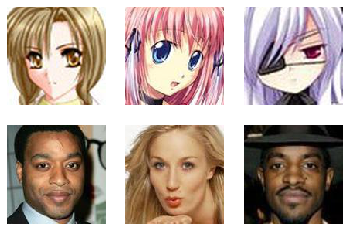

In [12]:
dataA = genA.next()
dataB = genB.next()

n_samples = 3

for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow((dataA[i] * 255).astype('uint8'))

for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow((dataB[i] * 255).astype('uint8'))
plt.show()

In [2]:
!sudo pip install git+https: // www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-39s3jg0v
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-39s3jg0v
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=080fe40a67c5ebad135759264b2186527450394351f7763ab1431a16e1f2df0a
  Stored in directory: /tmp/pip-ephem-wheel-cache-2e_s89mc/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot
import os

# define the discriminator model


def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_image = Input(shape=image_shape)
    # C64
    d = Conv2D(64, (4, 4),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4, 4),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4, 4),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4, 4),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4, 4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)
    # define model
    model = Model(in_image, patch_out)
    # compile model
    model.compile(loss='mse',
                  optimizer=Adam(lr=0.0002, beta_1=0.5),
                  loss_weights=[0.5])
    return model


# generator a resnet block


def resnet_block(n_filters, input_layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # first layer convolutional layer
    g = Conv2D(n_filters, (3, 3), padding='same',
               kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # second convolutional layer
    g = Conv2D(n_filters, (3, 3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    # concatenate merge channel-wise with input layer
    g = Concatenate()([g, input_layer])
    return g


# define the standalone generator model


def define_generator(image_shape, n_resnet=6):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # c7s1-64
    g = Conv2D(64, (7, 7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d128
    g = Conv2D(128, (3, 3),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d256
    g = Conv2D(256, (3, 3),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    # u128
    g = Conv2DTranspose(128, (3, 3),
                        strides=(2, 2),
                        padding='same',
                        kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # u64
    g = Conv2DTranspose(64, (3, 3),
                        strides=(2, 2),
                        padding='same',
                        kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # c7s1-3
    g = Conv2D(3, (7, 7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model


# define a composite model for updating generators by adversarial and cycle loss


def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    # ensure the model we're updating is trainable
    g_model_1.trainable = True
    # mark discriminator as not trainable
    d_model.trainable = False
    # mark other generator model as not trainable
    g_model_2.trainable = False
    # discriminator element
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    # identity element
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # forward cycle
    output_f = g_model_2(gen1_out)
    # backward cycle
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    # define model graph
    model = Model([input_gen, input_id],
                  [output_d, output_id, output_f, output_b])
    # define optimization algorithm configuration
    opt = Adam(lr=0.0002, beta_1=0.5)
    # compile model with weighting of least squares loss and L1 loss
    model.compile(loss=['mse', 'mae', 'mae', 'mae'],
                  loss_weights=[1, 5, 10, 10],
                  optimizer=opt)
    return model


# select a batch of random samples, returns images and target


def generate_real_samples(gen, n_samples, patch_shape):
    X = gen.next()
    X = (X * 2.) - 1.
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return X, y


# generate a batch of images, returns images and targets


def generate_fake_samples(g_model, dataset, patch_shape):
    # generate fake instance
    X = g_model.predict(dataset)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y


# save the generator models to file


def save_models(step, g_model_AtoB, g_model_BtoA, timestamp):
    # save the first generator model
    filename1 = 'g_model_AtoB_%06d.h5' % (step + 1)
    g_model_AtoB.save(os.path.join(timestamp, filename1))
    # save the second generator model
    filename2 = 'g_model_BtoA_%06d.h5' % (step + 1)
    g_model_BtoA.save(os.path.join(timestamp, filename2))
    print('>Saved: %s and %s' % (filename1, filename2))


# generate samples and save as a plot and save the model


def summarize_performance(step, g_model, trainX, name, timestamp, n_samples=4):
    # select a sample of input images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    # generate translated images
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    # scale all pixels from [-1,1] to [0,1]
    X_in = (X_in + 1.) / 2.0
    X_out = (X_out + 1.) / 2.0

    # plot real images
    pyplot.figure(figsize=(20, 15))
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_in[i])
    # plot translated image
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_out[i])
    # save plot to file
    filename1 = '%s_generated_plot_%06d.png' % (name, (step + 1))
    pyplot.savefig(os.path.join(timestamp, filename1))
    pyplot.close()


# update image pool for fake images


def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            # use image, but don't add it to the pool
            selected.append(image)
        else:
            # replace an existing image and use replaced image
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return asarray(selected)


# train cyclegan models
    

def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB,
          c_model_BtoA, dataset_size):
    n_epochs, n_batch = 100, 4
    n_patch = d_model_A.output_shape[1]

    datagen = ImageDataGenerator(rescale=1. / 255)

    trainA = datagen.flow_from_directory('data/train/human',
                                         target_size=(128, 128),
                                         batch_size=n_batch,
                                         class_mode=None)

    trainB = datagen.flow_from_directory('data/train/anime',
                                         target_size=(128, 128),
                                         batch_size=n_batch,
                                         class_mode=None)

    poolA, poolB = list(), list()
    bat_per_epo = int(dataset_size / n_batch)
    n_steps = bat_per_epo * n_epochs
    
    timestamp = time.strftime("%Y-%m-%d_%H:%M:%S")
    if not os.path.isdir(timestamp):
        os.mkdir(timestamp)
    
    for i in range(n_steps):
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        
        
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB,
                                                 n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA,
                                                 n_patch)
        
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        
        g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch(
            [X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch(
            [X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        
        if (i + 1) % 10 == 0:
            print(
                '>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' %
                (i + 1, dA_loss1, dA_loss2, dB_loss1, dB_loss2, g_loss1, g_loss2))
            
        if (i + 1) % (bat_per_epo * 1) == 0:
            print('\t>> Epoch %d' % ((i + 1) // bat_per_epo))
            summarize_performance(i, g_model_AtoB, trainA, 'AtoB', timestamp)
            summarize_performance(i, g_model_BtoA, trainB, 'BtoA', timestamp)
            
        if (i + 1) % (bat_per_epo * 3) == 0:
            save_models(i, g_model_AtoB, g_model_BtoA, timestamp)

Using TensorFlow backend.


In [34]:
image_shape = (128, 128, 3)
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA,
                                      image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB,
                                      image_shape)

In [7]:
from keras.models import load_model
cust = {'InstanceNormalization': InstanceNormalization}
image_shape = (128, 128, 3)
# generator: A -> B
g_model_AtoB = load_model('last4/g_model_AtoB_000667.h5', cust)
# generator: B -> A
g_model_BtoA = load_model('last4/g_model_BtoA_000667.h5', cust)
# discriminator: A -> [real/fake]
d_model_A = load_model('last4/d_model_A000667.h5', cust)
# discriminator: B -> [real/fake]
d_model_B = load_model('last4/d_model_B000667.h5', cust)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = load_model('last4/c_model_AtoB000667.h5', cust)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = load_model('last4/c_model_BtoA000667.h5', cust)

W0115 10:56:08.776451 139727948199744 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:4409: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0115 10:56:09.783198 139727948199744 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0115 10:56:09.784625 139727948199744 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0115 10:56:09.785293 139727948199744 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:203: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

/usr/local/lib/python3.7/dist-packages/keras/engine/s

In [8]:
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB,
      c_model_BtoA)

Found 64086 images belonging to 1 classes.
Found 63569 images belonging to 1 classes.
2500
>1, dA[0.030,0.016] dB[0.012,0.022] g[2.712,3.039]
>2, dA[0.007,0.022] dB[0.138,0.015] g[2.375,2.536]
>3, dA[0.005,0.007] dB[0.037,0.021] g[2.055,2.079]
>4, dA[0.010,0.002] dB[0.009,0.033] g[2.058,2.081]
>5, dA[0.011,0.004] dB[0.038,0.004] g[1.999,1.919]
>6, dA[0.003,0.004] dB[0.038,0.007] g[2.033,2.068]
>7, dA[0.006,0.006] dB[0.012,0.040] g[2.067,2.072]
>8, dA[0.046,0.010] dB[0.018,0.011] g[1.763,1.775]
>9, dA[0.015,0.005] dB[0.008,0.015] g[2.142,2.062]
>10, dA[0.016,0.018] dB[0.006,0.011] g[2.052,1.920]
>11, dA[0.010,0.007] dB[0.009,0.004] g[1.850,1.963]
>12, dA[0.004,0.006] dB[0.013,0.010] g[2.379,2.492]
>13, dA[0.003,0.004] dB[0.018,0.019] g[2.157,2.070]
>14, dA[0.006,0.012] dB[0.004,0.014] g[1.939,1.843]
>15, dA[0.004,0.010] dB[0.006,0.006] g[1.819,2.047]
>16, dA[0.005,0.023] dB[0.008,0.010] g[2.047,2.168]
>17, dA[0.004,0.005] dB[0.008,0.009] g[1.807,1.865]
>18, dA[0.005,0.006] dB[0.006,0.00

>156, dA[0.004,0.002] dB[0.006,0.002] g[1.654,1.556]
>157, dA[0.002,0.003] dB[0.005,0.003] g[1.847,1.782]
>158, dA[0.001,0.003] dB[0.005,0.002] g[1.546,1.692]
>159, dA[0.004,0.004] dB[0.003,0.003] g[1.583,1.551]
>160, dA[0.001,0.003] dB[0.002,0.003] g[1.876,1.721]
>161, dA[0.002,0.002] dB[0.003,0.003] g[2.229,2.042]
>162, dA[0.004,0.002] dB[0.013,0.005] g[1.813,1.830]
>163, dA[0.003,0.002] dB[0.005,0.003] g[1.792,1.804]
>164, dA[0.003,0.001] dB[0.010,0.002] g[1.637,1.667]
>165, dA[0.004,0.004] dB[0.011,0.003] g[1.686,1.837]
>166, dA[0.002,0.003] dB[0.006,0.004] g[1.590,1.594]
>167, dA[0.002,0.002] dB[0.005,0.009] g[1.699,1.565]
>168, dA[0.005,0.002] dB[0.005,0.003] g[1.759,1.862]
>169, dA[0.007,0.003] dB[0.002,0.005] g[1.619,1.692]
>170, dA[0.003,0.011] dB[0.006,0.003] g[1.496,1.556]
>171, dA[0.012,0.002] dB[0.006,0.005] g[1.669,1.854]
>172, dA[0.003,0.002] dB[0.004,0.018] g[2.042,1.965]
>173, dA[0.006,0.003] dB[0.006,0.003] g[1.462,1.457]
>174, dA[0.003,0.002] dB[0.006,0.006] g[1.763,

>311, dA[0.001,0.002] dB[0.004,0.002] g[1.615,1.676]
>312, dA[0.001,0.002] dB[0.002,0.002] g[1.687,1.861]
>313, dA[0.002,0.004] dB[0.003,0.003] g[1.642,1.559]
>314, dA[0.002,0.002] dB[0.002,0.002] g[1.653,1.648]
>315, dA[0.002,0.001] dB[0.002,0.003] g[1.670,1.823]
>316, dA[0.003,0.002] dB[0.003,0.001] g[1.443,1.310]
>317, dA[0.002,0.004] dB[0.003,0.003] g[1.938,2.115]
>318, dA[0.002,0.003] dB[0.003,0.002] g[1.831,1.858]
>319, dA[0.004,0.003] dB[0.003,0.006] g[2.007,2.018]
>320, dA[0.002,0.003] dB[0.009,0.003] g[1.518,1.355]
>321, dA[0.002,0.003] dB[0.004,0.021] g[1.732,1.565]
>322, dA[0.003,0.002] dB[0.004,0.002] g[1.538,1.545]
>323, dA[0.002,0.001] dB[0.003,0.003] g[1.815,1.548]
>324, dA[0.002,0.002] dB[0.009,0.003] g[1.451,1.475]
>325, dA[0.001,0.003] dB[0.002,0.002] g[1.730,1.556]
>326, dA[0.001,0.003] dB[0.006,0.028] g[1.921,1.867]
>327, dA[0.002,0.001] dB[0.008,0.005] g[1.926,1.893]
>328, dA[0.002,0.001] dB[0.006,0.002] g[1.730,1.730]
>329, dA[0.002,0.002] dB[0.007,0.004] g[1.846,

>466, dA[0.001,0.002] dB[0.003,0.003] g[1.420,1.491]
>467, dA[0.002,0.002] dB[0.003,0.003] g[1.583,1.609]
>468, dA[0.003,0.003] dB[0.004,0.002] g[1.438,1.336]
>469, dA[0.002,0.001] dB[0.003,0.003] g[1.667,1.725]
>470, dA[0.001,0.007] dB[0.002,0.002] g[1.457,1.468]
>471, dA[0.002,0.002] dB[0.002,0.006] g[1.464,1.604]
>472, dA[0.001,0.002] dB[0.009,0.002] g[1.713,2.025]
>473, dA[0.002,0.001] dB[0.004,0.002] g[1.481,1.496]
>474, dA[0.003,0.001] dB[0.004,0.004] g[1.727,1.752]
>475, dA[0.001,0.001] dB[0.002,0.004] g[1.730,1.753]
>476, dA[0.002,0.002] dB[0.003,0.002] g[1.795,1.931]
>477, dA[0.002,0.002] dB[0.002,0.006] g[1.392,1.362]
>478, dA[0.003,0.001] dB[0.002,0.006] g[1.447,1.525]
>479, dA[0.002,0.002] dB[0.007,0.001] g[2.184,2.217]
>480, dA[0.002,0.004] dB[0.008,0.004] g[1.609,1.637]
>481, dA[0.002,0.003] dB[0.002,0.003] g[1.635,1.676]
>482, dA[0.002,0.003] dB[0.003,0.002] g[1.853,1.976]
>483, dA[0.002,0.001] dB[0.002,0.004] g[1.696,1.709]
>484, dA[0.001,0.002] dB[0.002,0.004] g[1.440,

>621, dA[0.002,0.002] dB[0.001,0.003] g[1.481,1.437]
>622, dA[0.006,0.001] dB[0.003,0.002] g[1.477,1.343]
>623, dA[0.007,0.002] dB[0.003,0.005] g[1.690,1.864]
>624, dA[0.004,0.004] dB[0.002,0.004] g[1.412,1.385]
>625, dA[0.005,0.003] dB[0.003,0.003] g[1.454,1.557]
>626, dA[0.005,0.003] dB[0.002,0.002] g[1.594,1.486]
>627, dA[0.004,0.010] dB[0.002,0.002] g[1.809,1.860]
>628, dA[0.004,0.004] dB[0.001,0.002] g[1.683,1.959]
>629, dA[0.007,0.002] dB[0.002,0.001] g[1.319,1.395]
>630, dA[0.002,0.002] dB[0.002,0.002] g[1.462,1.633]
>631, dA[0.002,0.001] dB[0.002,0.002] g[1.603,1.718]
>632, dA[0.002,0.001] dB[0.001,0.007] g[1.492,1.479]
>633, dA[0.004,0.002] dB[0.002,0.002] g[1.181,1.249]
>634, dA[0.002,0.001] dB[0.002,0.003] g[1.364,1.511]
>635, dA[0.001,0.002] dB[0.002,0.003] g[1.291,1.544]
>636, dA[0.001,0.001] dB[0.010,0.003] g[1.529,1.558]
>637, dA[0.002,0.001] dB[0.003,0.004] g[1.313,1.254]
>638, dA[0.002,0.001] dB[0.004,0.002] g[1.348,1.375]
>639, dA[0.002,0.002] dB[0.002,0.001] g[1.521,

>776, dA[0.002,0.002] dB[0.003,0.003] g[1.510,1.430]
>777, dA[0.002,0.002] dB[0.006,0.002] g[1.428,1.364]
>778, dA[0.003,0.002] dB[0.002,0.022] g[1.653,1.700]
>779, dA[0.002,0.001] dB[0.010,0.003] g[1.376,1.425]
>780, dA[0.003,0.004] dB[0.007,0.005] g[1.441,1.549]
>781, dA[0.002,0.004] dB[0.002,0.002] g[1.622,1.675]
>782, dA[0.003,0.003] dB[0.002,0.005] g[1.581,1.786]
>783, dA[0.007,0.002] dB[0.003,0.002] g[1.665,1.661]
>784, dA[0.004,0.005] dB[0.002,0.001] g[1.296,1.216]
>785, dA[0.003,0.003] dB[0.003,0.002] g[1.413,1.420]
>786, dA[0.001,0.001] dB[0.004,0.002] g[1.311,1.352]
>787, dA[0.001,0.001] dB[0.003,0.005] g[1.482,1.394]
>788, dA[0.003,0.001] dB[0.002,0.005] g[1.620,1.674]
>789, dA[0.003,0.001] dB[0.003,0.002] g[1.394,1.396]
>790, dA[0.003,0.002] dB[0.002,0.002] g[1.526,1.586]
>791, dA[0.003,0.002] dB[0.004,0.002] g[1.332,1.421]
>792, dA[0.004,0.006] dB[0.003,0.002] g[1.708,1.650]
>793, dA[0.010,0.002] dB[0.003,0.002] g[1.663,1.709]
>794, dA[0.007,0.002] dB[0.004,0.003] g[1.751,

>931, dA[0.003,0.001] dB[0.004,0.016] g[1.401,1.420]
>932, dA[0.006,0.005] dB[0.003,0.008] g[1.529,1.710]
>933, dA[0.009,0.010] dB[0.010,0.002] g[1.579,1.381]
>934, dA[0.006,0.005] dB[0.005,0.003] g[1.587,1.545]
>935, dA[0.004,0.004] dB[0.002,0.002] g[1.392,1.339]
>936, dA[0.004,0.003] dB[0.002,0.001] g[1.248,1.331]
>937, dA[0.003,0.002] dB[0.001,0.001] g[1.985,1.855]
>938, dA[0.002,0.003] dB[0.001,0.002] g[1.621,1.863]
>939, dA[0.003,0.002] dB[0.002,0.001] g[1.322,1.259]
>940, dA[0.001,0.003] dB[0.002,0.002] g[1.597,1.572]
>941, dA[0.003,0.002] dB[0.001,0.002] g[1.948,2.231]
>942, dA[0.006,0.003] dB[0.003,0.002] g[1.413,1.515]
>943, dA[0.005,0.005] dB[0.002,0.001] g[1.418,1.490]
>944, dA[0.005,0.003] dB[0.002,0.002] g[1.486,1.604]
>945, dA[0.004,0.004] dB[0.004,0.004] g[1.215,1.255]
>946, dA[0.003,0.002] dB[0.002,0.006] g[1.383,1.443]
>947, dA[0.001,0.003] dB[0.002,0.004] g[1.528,1.517]
>948, dA[0.002,0.002] dB[0.009,0.001] g[1.243,1.167]
>949, dA[0.004,0.002] dB[0.002,0.007] g[1.581,

>1084, dA[0.002,0.002] dB[0.005,0.005] g[1.308,1.210]
>1085, dA[0.003,0.002] dB[0.004,0.005] g[1.548,1.468]
>1086, dA[0.000,0.001] dB[0.003,0.003] g[1.423,1.358]
>1087, dA[0.001,0.001] dB[0.002,0.003] g[1.658,1.496]
>1088, dA[0.001,0.001] dB[0.003,0.014] g[1.488,1.427]
>1089, dA[0.001,0.002] dB[0.025,0.004] g[1.320,1.325]
>1090, dA[0.002,0.001] dB[0.004,0.007] g[1.403,1.451]
>1091, dA[0.002,0.001] dB[0.003,0.008] g[1.596,1.856]
>1092, dA[0.001,0.001] dB[0.010,0.006] g[1.288,1.441]
>1093, dA[0.001,0.001] dB[0.005,0.004] g[1.464,1.358]
>1094, dA[0.001,0.001] dB[0.004,0.005] g[1.599,1.654]
>1095, dA[0.002,0.001] dB[0.004,0.003] g[1.380,1.439]
>1096, dA[0.002,0.001] dB[0.007,0.003] g[1.532,1.520]
>1097, dA[0.002,0.001] dB[0.003,0.003] g[1.494,1.569]
>1098, dA[0.002,0.001] dB[0.006,0.003] g[1.202,1.200]
>1099, dA[0.001,0.002] dB[0.003,0.002] g[1.306,1.327]
>1100, dA[0.001,0.001] dB[0.002,0.001] g[1.545,1.649]
>1101, dA[0.001,0.001] dB[0.004,0.002] g[1.685,1.529]
>1102, dA[0.001,0.001] dB[0.

>1236, dA[0.001,0.002] dB[0.001,0.002] g[1.563,1.898]
>1237, dA[0.003,0.002] dB[0.006,0.002] g[1.688,1.678]
>1238, dA[0.002,0.002] dB[0.002,0.003] g[1.828,1.711]
>1239, dA[0.004,0.001] dB[0.002,0.003] g[1.443,1.489]
>1240, dA[0.002,0.002] dB[0.003,0.001] g[1.596,1.507]
>1241, dA[0.002,0.002] dB[0.002,0.002] g[1.621,1.686]
>1242, dA[0.002,0.002] dB[0.003,0.001] g[1.603,1.581]
>1243, dA[0.004,0.001] dB[0.002,0.001] g[1.276,1.320]
>1244, dA[0.004,0.002] dB[0.002,0.001] g[1.823,1.945]
>1245, dA[0.005,0.002] dB[0.003,0.003] g[1.668,1.686]
>1246, dA[0.009,0.005] dB[0.002,0.003] g[1.182,1.437]
>1247, dA[0.011,0.007] dB[0.002,0.005] g[1.940,2.140]
>1248, dA[0.010,0.009] dB[0.003,0.004] g[1.594,1.624]
>1249, dA[0.007,0.008] dB[0.002,0.005] g[1.688,1.737]
>1250, dA[0.005,0.006] dB[0.003,0.003] g[1.735,1.853]
>1251, dA[0.005,0.002] dB[0.005,0.002] g[1.458,1.637]
>1252, dA[0.001,0.001] dB[0.004,0.007] g[1.554,1.491]
>1253, dA[0.001,0.001] dB[0.002,0.006] g[1.263,1.322]
>1254, dA[0.001,0.001] dB[0.

>1388, dA[0.010,0.004] dB[0.003,0.002] g[1.210,1.311]
>1389, dA[0.010,0.003] dB[0.002,0.002] g[1.440,1.463]
>1390, dA[0.002,0.002] dB[0.001,0.002] g[1.828,1.794]
>1391, dA[0.001,0.002] dB[0.002,0.003] g[1.644,1.663]
>1392, dA[0.001,0.004] dB[0.005,0.002] g[1.599,1.485]
>1393, dA[0.003,0.001] dB[0.004,0.002] g[1.612,1.708]
>1394, dA[0.001,0.002] dB[0.003,0.004] g[1.447,1.454]
>1395, dA[0.001,0.001] dB[0.002,0.003] g[1.467,1.430]
>1396, dA[0.001,0.001] dB[0.003,0.001] g[1.361,1.412]
>1397, dA[0.001,0.002] dB[0.003,0.002] g[1.377,1.461]
>1398, dA[0.001,0.005] dB[0.002,0.002] g[1.567,1.532]
>1399, dA[0.005,0.001] dB[0.001,0.002] g[1.398,1.321]
>1400, dA[0.003,0.001] dB[0.003,0.003] g[1.272,1.360]
>1401, dA[0.009,0.002] dB[0.002,0.001] g[1.383,1.425]
>1402, dA[0.003,0.002] dB[0.002,0.004] g[1.465,1.453]
>1403, dA[0.004,0.002] dB[0.002,0.002] g[1.100,1.166]
>1404, dA[0.004,0.001] dB[0.002,0.001] g[1.433,1.637]
>1405, dA[0.004,0.001] dB[0.002,0.001] g[1.330,1.295]
>1406, dA[0.003,0.002] dB[0.

>1540, dA[0.001,0.000] dB[0.002,0.001] g[1.558,1.422]
>1541, dA[0.000,0.000] dB[0.002,0.001] g[1.359,1.428]
>1542, dA[0.001,0.001] dB[0.002,0.001] g[1.612,1.743]
>1543, dA[0.001,0.001] dB[0.001,0.001] g[1.440,1.440]
>1544, dA[0.001,0.001] dB[0.001,0.001] g[1.157,1.271]
>1545, dA[0.002,0.002] dB[0.002,0.002] g[1.410,1.544]
>1546, dA[0.002,0.003] dB[0.002,0.001] g[1.346,1.407]
>1547, dA[0.005,0.003] dB[0.001,0.002] g[1.699,1.665]
>1548, dA[0.006,0.002] dB[0.001,0.003] g[1.331,1.502]
>1549, dA[0.002,0.001] dB[0.004,0.004] g[1.512,1.497]
>1550, dA[0.003,0.004] dB[0.004,0.002] g[1.448,1.522]
>1551, dA[0.002,0.001] dB[0.002,0.003] g[1.586,1.668]
>1552, dA[0.002,0.001] dB[0.002,0.002] g[1.320,1.381]
>1553, dA[0.004,0.002] dB[0.003,0.002] g[1.726,1.683]
>1554, dA[0.003,0.002] dB[0.002,0.002] g[1.305,1.330]
>1555, dA[0.003,0.001] dB[0.002,0.002] g[1.465,1.583]
>1556, dA[0.002,0.001] dB[0.001,0.001] g[1.442,1.689]
>1557, dA[0.001,0.001] dB[0.001,0.001] g[1.348,1.424]
>1558, dA[0.001,0.001] dB[0.

>1692, dA[0.001,0.002] dB[0.002,0.002] g[1.457,1.379]
>1693, dA[0.001,0.002] dB[0.002,0.001] g[1.317,1.338]
>1694, dA[0.002,0.002] dB[0.009,0.007] g[1.432,1.354]
>1695, dA[0.002,0.001] dB[0.003,0.045] g[1.638,1.427]
>1696, dA[0.005,0.007] dB[0.016,0.008] g[1.517,1.514]
>1697, dA[0.007,0.004] dB[0.061,0.032] g[1.306,1.299]
>1698, dA[0.005,0.002] dB[0.012,0.005] g[1.504,1.301]
>1699, dA[0.005,0.003] dB[0.020,0.008] g[1.396,1.269]
>1700, dA[0.002,0.002] dB[0.005,0.004] g[1.367,1.396]
>1701, dA[0.002,0.002] dB[0.044,0.026] g[1.191,1.315]
>1702, dA[0.002,0.002] dB[0.008,0.002] g[1.260,1.258]
>1703, dA[0.003,0.002] dB[0.019,0.006] g[1.531,1.494]
>1704, dA[0.001,0.002] dB[0.010,0.004] g[1.256,1.154]
>1705, dA[0.001,0.001] dB[0.007,0.011] g[1.584,1.599]
>1706, dA[0.002,0.001] dB[0.016,0.007] g[1.411,1.289]
>1707, dA[0.001,0.002] dB[0.004,0.005] g[1.315,1.390]
>1708, dA[0.002,0.001] dB[0.004,0.003] g[1.308,1.288]
>1709, dA[0.002,0.001] dB[0.002,0.005] g[1.265,1.380]
>1710, dA[0.001,0.002] dB[0.

>1844, dA[0.003,0.002] dB[0.005,0.003] g[1.559,1.731]
>1845, dA[0.003,0.002] dB[0.002,0.003] g[1.241,1.209]
>1846, dA[0.002,0.003] dB[0.001,0.002] g[1.435,1.466]
>1847, dA[0.002,0.002] dB[0.005,0.006] g[1.772,1.799]
>1848, dA[0.003,0.002] dB[0.003,0.004] g[1.440,1.422]
>1849, dA[0.001,0.001] dB[0.001,0.002] g[1.569,1.469]
>1850, dA[0.002,0.000] dB[0.001,0.002] g[1.289,1.303]
>1851, dA[0.001,0.000] dB[0.002,0.001] g[1.474,1.571]
>1852, dA[0.001,0.001] dB[0.001,0.001] g[1.344,1.230]
>1853, dA[0.001,0.001] dB[0.004,0.001] g[1.265,1.264]
>1854, dA[0.001,0.001] dB[0.003,0.001] g[1.338,1.179]
>1855, dA[0.001,0.001] dB[0.002,0.001] g[1.407,1.421]
>1856, dA[0.001,0.001] dB[0.002,0.001] g[1.267,1.236]
>1857, dA[0.001,0.001] dB[0.002,0.001] g[1.228,1.230]
>1858, dA[0.001,0.001] dB[0.001,0.003] g[1.235,1.296]
>1859, dA[0.001,0.001] dB[0.001,0.034] g[1.488,1.565]
>1860, dA[0.002,0.002] dB[0.031,0.005] g[1.360,1.559]
>1861, dA[0.002,0.002] dB[0.007,0.011] g[1.561,1.513]
>1862, dA[0.000,0.002] dB[0.

>1996, dA[0.001,0.001] dB[0.016,0.003] g[1.413,1.538]
>1997, dA[0.001,0.001] dB[0.002,0.004] g[2.104,2.324]
>1998, dA[0.001,0.001] dB[0.003,0.001] g[1.319,1.356]
>1999, dA[0.001,0.001] dB[0.002,0.001] g[1.737,1.727]
>2000, dA[0.003,0.001] dB[0.002,0.002] g[1.379,1.507]
>2001, dA[0.002,0.001] dB[0.002,0.001] g[1.321,1.448]
>2002, dA[0.001,0.001] dB[0.004,0.003] g[1.544,1.752]
>2003, dA[0.001,0.002] dB[0.002,0.002] g[1.524,1.642]
>2004, dA[0.001,0.001] dB[0.001,0.001] g[1.281,1.338]
>2005, dA[0.001,0.001] dB[0.001,0.003] g[1.353,1.566]
>2006, dA[0.001,0.001] dB[0.003,0.001] g[1.459,1.704]
>2007, dA[0.001,0.001] dB[0.003,0.002] g[1.182,1.210]
>2008, dA[0.001,0.001] dB[0.001,0.001] g[1.244,1.274]
>2009, dA[0.001,0.001] dB[0.002,0.001] g[1.272,1.402]
>2010, dA[0.002,0.001] dB[0.005,0.004] g[1.171,1.118]
>2011, dA[0.001,0.001] dB[0.001,0.001] g[1.756,1.742]
>2012, dA[0.001,0.002] dB[0.004,0.001] g[1.510,1.548]
>2013, dA[0.001,0.001] dB[0.003,0.001] g[1.471,1.470]
>2014, dA[0.001,0.001] dB[0.

>2148, dA[0.024,0.004] dB[0.003,0.001] g[1.693,1.648]
>2149, dA[0.010,0.032] dB[0.002,0.002] g[1.168,1.229]
>2150, dA[0.007,0.005] dB[0.003,0.001] g[1.614,1.497]
>2151, dA[0.045,0.021] dB[0.001,0.001] g[1.402,1.425]
>2152, dA[0.011,0.005] dB[0.001,0.001] g[1.314,1.324]
>2153, dA[0.011,0.002] dB[0.001,0.001] g[1.166,1.254]
>2154, dA[0.004,0.005] dB[0.002,0.001] g[1.306,1.348]
>2155, dA[0.005,0.006] dB[0.002,0.009] g[1.491,1.559]
>2156, dA[0.008,0.002] dB[0.003,0.004] g[1.349,1.427]
>2157, dA[0.009,0.003] dB[0.001,0.004] g[1.362,1.515]
>2158, dA[0.006,0.006] dB[0.003,0.003] g[1.371,1.442]
>2159, dA[0.006,0.006] dB[0.002,0.001] g[1.480,1.416]
>2160, dA[0.005,0.004] dB[0.003,0.002] g[1.160,1.224]
>2161, dA[0.004,0.007] dB[0.002,0.003] g[1.554,1.167]
>2162, dA[0.002,0.001] dB[0.002,0.002] g[1.457,1.254]
>2163, dA[0.002,0.001] dB[0.002,0.001] g[1.661,1.694]
>2164, dA[0.008,0.006] dB[0.005,0.003] g[1.519,1.498]
>2165, dA[0.005,0.005] dB[0.003,0.003] g[1.329,1.374]
>2166, dA[0.005,0.003] dB[0.

>2300, dA[0.002,0.001] dB[0.003,0.003] g[1.478,1.481]
>2301, dA[0.001,0.001] dB[0.002,0.006] g[1.263,1.356]
>2302, dA[0.001,0.001] dB[0.003,0.004] g[1.251,1.344]
>2303, dA[0.001,0.001] dB[0.004,0.012] g[1.821,2.269]
>2304, dA[0.001,0.001] dB[0.007,0.002] g[1.084,1.354]
>2305, dA[0.001,0.001] dB[0.005,0.003] g[1.613,1.851]
>2306, dA[0.001,0.002] dB[0.003,0.002] g[1.313,1.620]
>2307, dA[0.003,0.007] dB[0.004,0.002] g[1.329,1.316]
>2308, dA[0.001,0.003] dB[0.002,0.001] g[1.409,1.310]
>2309, dA[0.004,0.001] dB[0.003,0.001] g[1.150,1.255]
>2310, dA[0.002,0.002] dB[0.002,0.001] g[1.949,1.782]
>2311, dA[0.002,0.001] dB[0.003,0.001] g[1.286,1.274]
>2312, dA[0.003,0.001] dB[0.003,0.004] g[1.536,1.659]
>2313, dA[0.001,0.002] dB[0.004,0.003] g[1.418,1.568]
>2314, dA[0.001,0.001] dB[0.002,0.002] g[1.396,1.452]
>2315, dA[0.001,0.001] dB[0.001,0.002] g[1.403,1.524]
>2316, dA[0.001,0.002] dB[0.005,0.002] g[1.294,1.342]
>2317, dA[0.003,0.006] dB[0.003,0.002] g[1.105,1.090]
>2318, dA[0.003,0.003] dB[0.

>2452, dA[0.001,0.000] dB[0.001,0.002] g[1.360,1.416]
>2453, dA[0.001,0.001] dB[0.002,0.001] g[1.293,1.225]
>2454, dA[0.001,0.001] dB[0.002,0.001] g[1.523,1.482]
>2455, dA[0.003,0.001] dB[0.002,0.001] g[1.258,1.238]
>2456, dA[0.001,0.013] dB[0.001,0.003] g[1.592,1.552]
>2457, dA[0.012,0.003] dB[0.001,0.004] g[1.627,1.355]
>2458, dA[0.001,0.003] dB[0.002,0.003] g[1.429,1.535]
>2459, dA[0.002,0.002] dB[0.002,0.002] g[1.413,1.426]
>2460, dA[0.002,0.002] dB[0.002,0.002] g[1.259,1.257]
>2461, dA[0.003,0.005] dB[0.002,0.001] g[1.837,1.931]
>2462, dA[0.007,0.004] dB[0.003,0.001] g[1.260,1.408]
>2463, dA[0.010,0.005] dB[0.003,0.003] g[1.638,1.670]
>2464, dA[0.006,0.004] dB[0.002,0.001] g[1.181,1.230]
>2465, dA[0.006,0.005] dB[0.001,0.001] g[1.370,1.403]
>2466, dA[0.005,0.005] dB[0.001,0.002] g[1.445,1.444]
>2467, dA[0.004,0.005] dB[0.002,0.002] g[1.141,1.150]
>2468, dA[0.003,0.005] dB[0.003,0.001] g[1.597,1.537]
>2469, dA[0.002,0.002] dB[0.004,0.002] g[1.514,1.644]
>2470, dA[0.003,0.002] dB[0.

>2604, dA[0.001,0.000] dB[0.002,0.002] g[1.359,1.549]
>2605, dA[0.000,0.001] dB[0.002,0.001] g[1.463,1.642]
>2606, dA[0.000,0.000] dB[0.002,0.001] g[1.219,1.256]
>2607, dA[0.000,0.001] dB[0.002,0.002] g[1.614,1.748]
>2608, dA[0.001,0.001] dB[0.001,0.001] g[1.429,1.489]
>2609, dA[0.001,0.001] dB[0.003,0.001] g[1.348,1.615]
>2610, dA[0.001,0.001] dB[0.001,0.001] g[1.093,1.204]
>2611, dA[0.001,0.001] dB[0.001,0.001] g[1.425,1.494]
>2612, dA[0.000,0.001] dB[0.001,0.001] g[1.356,1.529]
>2613, dA[0.001,0.000] dB[0.001,0.001] g[1.483,1.476]
>2614, dA[0.001,0.000] dB[0.001,0.001] g[1.211,1.357]
>2615, dA[0.001,0.000] dB[0.001,0.002] g[1.450,1.286]
>2616, dA[0.001,0.001] dB[0.002,0.001] g[1.116,1.068]
>2617, dA[0.001,0.001] dB[0.002,0.001] g[1.177,1.151]
>2618, dA[0.001,0.000] dB[0.002,0.001] g[1.213,1.413]
>2619, dA[0.001,0.000] dB[0.001,0.001] g[1.440,1.581]
>2620, dA[0.001,0.000] dB[0.001,0.001] g[1.304,1.209]
>2621, dA[0.001,0.000] dB[0.001,0.001] g[1.475,1.475]
>2622, dA[0.001,0.001] dB[0.

>2756, dA[0.001,0.001] dB[0.002,0.001] g[1.171,1.233]
>2757, dA[0.001,0.001] dB[0.001,0.004] g[1.388,1.746]
>2758, dA[0.001,0.001] dB[0.001,0.002] g[1.649,1.593]
>2759, dA[0.001,0.001] dB[0.002,0.001] g[1.438,1.311]
>2760, dA[0.001,0.001] dB[0.001,0.001] g[1.336,1.437]
>2761, dA[0.001,0.001] dB[0.001,0.001] g[1.451,1.472]
>2762, dA[0.001,0.001] dB[0.005,0.003] g[1.203,1.204]
>2763, dA[0.001,0.002] dB[0.001,0.002] g[1.135,1.283]
>2764, dA[0.001,0.002] dB[0.002,0.003] g[1.110,1.389]
>2765, dA[0.001,0.001] dB[0.006,0.003] g[1.077,1.295]
>2766, dA[0.001,0.002] dB[0.006,0.004] g[1.446,1.557]
>2767, dA[0.001,0.001] dB[0.006,0.005] g[1.140,1.441]
>2768, dA[0.002,0.001] dB[0.003,0.005] g[1.435,1.415]
>2769, dA[0.002,0.001] dB[0.004,0.001] g[1.395,1.390]
>2770, dA[0.001,0.001] dB[0.002,0.002] g[1.252,1.227]
>2771, dA[0.002,0.002] dB[0.002,0.003] g[1.346,1.448]
>2772, dA[0.001,0.002] dB[0.002,0.002] g[1.245,1.241]
>2773, dA[0.002,0.001] dB[0.001,0.003] g[1.189,1.238]
>2774, dA[0.001,0.001] dB[0.

>2908, dA[0.001,0.001] dB[0.002,0.002] g[1.251,1.387]
>2909, dA[0.001,0.001] dB[0.002,0.001] g[1.122,1.191]
>2910, dA[0.002,0.001] dB[0.001,0.001] g[1.522,1.735]
>2911, dA[0.002,0.002] dB[0.002,0.001] g[1.165,1.182]
>2912, dA[0.001,0.001] dB[0.002,0.003] g[1.800,1.712]
>2913, dA[0.002,0.001] dB[0.002,0.001] g[1.312,1.317]
>2914, dA[0.002,0.001] dB[0.002,0.001] g[1.258,1.171]
>2915, dA[0.001,0.001] dB[0.004,0.001] g[1.317,1.331]
>2916, dA[0.005,0.001] dB[0.002,0.002] g[1.305,1.342]
>2917, dA[0.001,0.003] dB[0.001,0.001] g[1.356,1.358]
>2918, dA[0.002,0.001] dB[0.002,0.001] g[1.252,1.278]
>2919, dA[0.002,0.001] dB[0.001,0.004] g[1.713,1.876]
>2920, dA[0.001,0.001] dB[0.002,0.002] g[1.460,1.491]
>2921, dA[0.001,0.001] dB[0.001,0.002] g[1.220,1.148]
>2922, dA[0.001,0.002] dB[0.002,0.003] g[1.394,1.427]
>2923, dA[0.001,0.001] dB[0.003,0.001] g[1.205,1.267]
>2924, dA[0.001,0.001] dB[0.055,0.011] g[1.166,1.115]
>2925, dA[0.002,0.001] dB[0.006,0.005] g[1.351,1.283]
>2926, dA[0.001,0.030] dB[0.

>3060, dA[0.001,0.001] dB[0.001,0.078] g[1.362,1.625]
>3061, dA[0.001,0.001] dB[0.037,0.005] g[1.281,1.395]
>3062, dA[0.002,0.002] dB[0.007,0.008] g[1.264,1.297]
>3063, dA[0.001,0.001] dB[0.011,0.007] g[1.260,1.311]
>3064, dA[0.002,0.001] dB[0.007,0.005] g[1.237,1.238]
>3065, dA[0.001,0.001] dB[0.003,0.002] g[1.197,1.320]
>3066, dA[0.001,0.001] dB[0.002,0.003] g[1.023,1.132]
>3067, dA[0.001,0.001] dB[0.002,0.002] g[1.412,1.513]
>3068, dA[0.001,0.001] dB[0.003,0.002] g[1.266,1.375]
>3069, dA[0.001,0.001] dB[0.003,0.001] g[1.147,1.224]
>3070, dA[0.002,0.001] dB[0.002,0.005] g[1.183,1.322]
>3071, dA[0.001,0.001] dB[0.002,0.005] g[1.254,1.466]
>3072, dA[0.004,0.002] dB[0.004,0.003] g[1.594,1.853]
>3073, dA[0.001,0.001] dB[0.009,0.001] g[1.205,1.404]
>3074, dA[0.001,0.001] dB[0.002,0.003] g[1.264,1.401]
>3075, dA[0.001,0.001] dB[0.001,0.003] g[1.187,1.206]
>3076, dA[0.001,0.001] dB[0.002,0.001] g[1.147,1.182]
>3077, dA[0.001,0.001] dB[0.001,0.002] g[1.303,1.254]
>3078, dA[0.001,0.001] dB[0.

>3212, dA[0.001,0.001] dB[0.002,0.025] g[1.631,1.786]
>3213, dA[0.000,0.001] dB[0.054,0.032] g[1.166,1.354]
>3214, dA[0.001,0.001] dB[0.006,0.009] g[1.445,1.485]
>3215, dA[0.001,0.001] dB[0.013,0.043] g[1.428,1.580]
>3216, dA[0.002,0.001] dB[0.071,0.027] g[1.416,1.364]
>3217, dA[0.001,0.001] dB[0.006,0.010] g[1.376,1.277]
>3218, dA[0.001,0.001] dB[0.068,0.292] g[0.995,1.141]
>3219, dA[0.001,0.001] dB[0.187,0.015] g[1.304,1.280]
>3220, dA[0.001,0.001] dB[0.027,0.020] g[1.442,1.469]
>3221, dA[0.001,0.001] dB[0.010,0.018] g[1.564,1.514]
>3222, dA[0.001,0.001] dB[0.052,0.017] g[1.495,1.663]
>3223, dA[0.001,0.001] dB[0.013,0.016] g[1.332,1.329]
>3224, dA[0.001,0.002] dB[0.037,0.034] g[1.407,1.432]
>3225, dA[0.001,0.002] dB[0.010,0.015] g[1.247,1.354]
>3226, dA[0.001,0.001] dB[0.019,0.022] g[1.326,1.258]
>3227, dA[0.001,0.001] dB[0.017,0.030] g[1.392,1.601]
>3228, dA[0.001,0.003] dB[0.019,0.025] g[1.225,1.133]
>3229, dA[0.001,0.001] dB[0.030,0.058] g[1.429,1.414]
>3230, dA[0.002,0.001] dB[0.

>3364, dA[0.000,0.001] dB[0.001,0.001] g[1.167,1.236]
>3365, dA[0.001,0.001] dB[0.001,0.001] g[1.439,1.409]
>3366, dA[0.001,0.001] dB[0.000,0.004] g[1.300,1.452]
>3367, dA[0.001,0.001] dB[0.002,0.001] g[1.268,1.341]
>3368, dA[0.001,0.001] dB[0.004,0.002] g[1.493,1.466]
>3369, dA[0.001,0.000] dB[0.002,0.002] g[1.334,1.200]
>3370, dA[0.001,0.001] dB[0.003,0.002] g[1.616,1.676]
>3371, dA[0.001,0.001] dB[0.001,0.001] g[1.480,1.398]
>3372, dA[0.002,0.001] dB[0.001,0.001] g[1.462,1.612]
>3373, dA[0.003,0.001] dB[0.001,0.001] g[1.209,1.248]
>3374, dA[0.001,0.001] dB[0.001,0.001] g[1.456,1.611]
>3375, dA[0.001,0.001] dB[0.001,0.053] g[1.614,1.751]
>3376, dA[0.001,0.001] dB[0.013,0.005] g[1.284,1.218]
>3377, dA[0.002,0.001] dB[0.008,0.003] g[1.345,1.389]
>3378, dA[0.003,0.001] dB[0.010,0.004] g[1.418,1.397]
>3379, dA[0.001,0.001] dB[0.003,0.002] g[1.553,1.495]
>3380, dA[0.001,0.001] dB[0.001,0.002] g[1.163,1.123]
>3381, dA[0.001,0.001] dB[0.002,0.002] g[1.200,1.147]
>3382, dA[0.001,0.001] dB[0.

>3516, dA[0.001,0.001] dB[0.001,0.001] g[1.212,1.195]
>3517, dA[0.001,0.001] dB[0.001,0.001] g[1.167,1.165]
>3518, dA[0.001,0.001] dB[0.001,0.001] g[1.247,1.346]
>3519, dA[0.001,0.002] dB[0.009,0.003] g[1.297,1.249]
>3520, dA[0.001,0.001] dB[0.001,0.002] g[1.235,1.356]
>3521, dA[0.002,0.001] dB[0.003,0.002] g[1.095,1.009]
>3522, dA[0.003,0.001] dB[0.002,0.002] g[1.794,1.957]
>3523, dA[0.003,0.000] dB[0.002,0.003] g[1.516,1.513]
>3524, dA[0.003,0.001] dB[0.001,0.003] g[1.450,1.573]
>3525, dA[0.003,0.002] dB[0.001,0.002] g[1.272,1.384]
>3526, dA[0.003,0.001] dB[0.001,0.005] g[1.241,1.316]
>3527, dA[0.001,0.001] dB[0.001,0.001] g[1.367,1.289]
>3528, dA[0.001,0.001] dB[0.001,0.001] g[1.243,1.169]
>3529, dA[0.001,0.001] dB[0.001,0.005] g[1.460,1.445]
>3530, dA[0.000,0.001] dB[0.001,0.001] g[1.524,1.635]
>3531, dA[0.001,0.000] dB[0.001,0.001] g[1.210,1.282]
>3532, dA[0.000,0.001] dB[0.002,0.001] g[1.050,1.122]
>3533, dA[0.001,0.000] dB[0.001,0.001] g[1.084,1.158]
>3534, dA[0.000,0.000] dB[0.

>3668, dA[0.002,0.001] dB[0.002,0.001] g[1.350,1.347]
>3669, dA[0.001,0.001] dB[0.002,0.002] g[1.571,1.402]
>3670, dA[0.001,0.001] dB[0.002,0.001] g[1.164,1.343]
>3671, dA[0.002,0.001] dB[0.002,0.001] g[1.173,1.313]
>3672, dA[0.002,0.002] dB[0.002,0.001] g[1.543,1.444]
>3673, dA[0.003,0.003] dB[0.001,0.002] g[1.619,1.668]
>3674, dA[0.004,0.001] dB[0.001,0.001] g[1.428,1.380]
>3675, dA[0.003,0.001] dB[0.002,0.001] g[1.510,1.575]
>3676, dA[0.001,0.000] dB[0.001,0.001] g[1.382,1.192]
>3677, dA[0.001,0.001] dB[0.001,0.001] g[1.198,1.132]
>3678, dA[0.002,0.000] dB[0.001,0.001] g[1.234,1.417]
>3679, dA[0.001,0.000] dB[0.001,0.001] g[1.195,1.201]
>3680, dA[0.001,0.001] dB[0.001,0.001] g[1.117,1.156]
>3681, dA[0.001,0.001] dB[0.001,0.001] g[1.175,1.087]
>3682, dA[0.001,0.001] dB[0.001,0.001] g[1.271,1.172]
>3683, dA[0.001,0.001] dB[0.001,0.000] g[1.402,1.492]
>3684, dA[0.001,0.000] dB[0.001,0.001] g[1.197,1.196]
>3685, dA[0.001,0.001] dB[0.001,0.000] g[1.049,1.016]
>3686, dA[0.001,0.001] dB[0.

>3820, dA[0.001,0.002] dB[0.006,0.003] g[1.738,1.951]
>3821, dA[0.001,0.001] dB[0.002,0.001] g[1.443,1.634]
>3822, dA[0.001,0.002] dB[0.001,0.001] g[1.099,1.191]
>3823, dA[0.002,0.001] dB[0.002,0.001] g[1.631,1.828]
>3824, dA[0.002,0.001] dB[0.002,0.044] g[1.408,1.591]
>3825, dA[0.001,0.001] dB[0.011,0.003] g[1.412,1.269]
>3826, dA[0.001,0.001] dB[0.017,0.005] g[1.347,1.629]
>3827, dA[0.001,0.001] dB[0.005,0.002] g[1.142,1.160]
>3828, dA[0.001,0.001] dB[0.007,0.003] g[1.317,1.292]
>3829, dA[0.000,0.001] dB[0.003,0.003] g[1.259,1.362]
>3830, dA[0.001,0.001] dB[0.005,0.010] g[1.200,1.315]
>3831, dA[0.002,0.001] dB[0.003,0.010] g[1.172,1.116]
>3832, dA[0.002,0.003] dB[0.006,0.005] g[1.518,1.562]
>3833, dA[0.002,0.002] dB[0.011,0.003] g[1.197,1.139]
>3834, dA[0.002,0.002] dB[0.012,0.005] g[1.427,1.257]
>3835, dA[0.001,0.002] dB[0.012,0.012] g[1.423,1.382]
>3836, dA[0.000,0.001] dB[0.007,0.008] g[1.614,1.553]
>3837, dA[0.001,0.001] dB[0.002,0.003] g[1.293,1.182]
>3838, dA[0.001,0.001] dB[0.

>3972, dA[0.001,0.000] dB[0.003,0.001] g[1.131,1.230]
>3973, dA[0.001,0.000] dB[0.002,0.004] g[1.272,1.165]
>3974, dA[0.001,0.000] dB[0.002,0.003] g[1.169,1.224]
>3975, dA[0.001,0.001] dB[0.002,0.002] g[1.474,1.722]
>3976, dA[0.001,0.001] dB[0.003,0.001] g[1.254,1.286]
>3977, dA[0.001,0.000] dB[0.004,0.002] g[1.125,1.340]
>3978, dA[0.000,0.001] dB[0.004,0.002] g[1.548,1.657]
>3979, dA[0.001,0.001] dB[0.002,0.001] g[1.185,1.108]
>3980, dA[0.000,0.000] dB[0.002,0.004] g[1.158,1.258]
>3981, dA[0.001,0.000] dB[0.002,0.003] g[1.233,1.236]
>3982, dA[0.000,0.001] dB[0.002,0.002] g[1.387,1.584]
>3983, dA[0.001,0.001] dB[0.004,0.001] g[1.160,1.253]
>3984, dA[0.001,0.000] dB[0.003,0.001] g[1.181,1.343]
>3985, dA[0.001,0.000] dB[0.002,0.001] g[1.788,1.993]
>3986, dA[0.001,0.000] dB[0.002,0.001] g[1.138,1.153]
>3987, dA[0.001,0.001] dB[0.001,0.002] g[1.158,1.215]
>3988, dA[0.001,0.001] dB[0.001,0.046] g[1.141,1.286]
>3989, dA[0.001,0.001] dB[0.024,0.005] g[1.097,1.238]
>3990, dA[0.001,0.001] dB[0.

>4124, dA[0.001,0.001] dB[0.001,0.001] g[1.700,1.751]
>4125, dA[0.001,0.001] dB[0.000,0.001] g[1.374,1.442]
>4126, dA[0.001,0.001] dB[0.001,0.001] g[1.203,1.394]
>4127, dA[0.001,0.001] dB[0.001,0.001] g[1.425,1.555]
>4128, dA[0.001,0.001] dB[0.001,0.001] g[1.128,1.096]
>4129, dA[0.001,0.001] dB[0.002,0.001] g[1.404,1.362]
>4130, dA[0.001,0.001] dB[0.001,0.002] g[1.179,1.289]
>4131, dA[0.001,0.001] dB[0.002,0.001] g[1.419,1.537]
>4132, dA[0.001,0.001] dB[0.003,0.001] g[1.463,1.401]
>4133, dA[0.001,0.000] dB[0.002,0.001] g[1.155,1.224]
>4134, dA[0.001,0.000] dB[0.002,0.007] g[1.680,1.589]
>4135, dA[0.001,0.000] dB[0.004,0.001] g[1.421,1.411]
>4136, dA[0.001,0.000] dB[0.001,0.002] g[1.472,1.249]
>4137, dA[0.001,0.001] dB[0.002,0.002] g[1.213,1.209]
>4138, dA[0.001,0.001] dB[0.003,0.001] g[1.281,1.182]
>4139, dA[0.002,0.000] dB[0.004,0.003] g[1.481,1.646]
>4140, dA[0.000,0.001] dB[0.007,0.006] g[1.104,1.153]
>4141, dA[0.000,0.000] dB[0.007,0.002] g[1.635,1.458]
>4142, dA[0.000,0.000] dB[0.

>4276, dA[0.002,0.001] dB[0.005,0.053] g[1.545,1.413]
>4277, dA[0.002,0.002] dB[0.022,0.020] g[1.148,1.068]
>4278, dA[0.002,0.001] dB[0.029,0.007] g[1.563,1.688]
>4279, dA[0.001,0.001] dB[0.017,0.004] g[1.209,1.246]
>4280, dA[0.001,0.001] dB[0.004,0.005] g[1.325,1.216]
>4281, dA[0.001,0.001] dB[0.009,0.003] g[1.589,1.657]
>4282, dA[0.001,0.001] dB[0.007,0.006] g[1.393,1.314]
>4283, dA[0.001,0.002] dB[0.004,0.003] g[1.285,1.209]
>4284, dA[0.002,0.001] dB[0.003,0.001] g[1.272,1.290]
>4285, dA[0.002,0.002] dB[0.003,0.002] g[1.103,1.158]
>4286, dA[0.001,0.001] dB[0.002,0.002] g[1.449,1.352]
>4287, dA[0.001,0.000] dB[0.001,0.002] g[1.287,1.437]
>4288, dA[0.000,0.000] dB[0.001,0.005] g[1.387,1.326]
>4289, dA[0.000,0.000] dB[0.004,0.001] g[1.288,1.262]
>4290, dA[0.000,0.000] dB[0.002,0.002] g[1.361,1.321]
>4291, dA[0.001,0.000] dB[0.001,0.002] g[1.475,1.568]
>4292, dA[0.001,0.000] dB[0.001,0.002] g[1.092,1.146]
>4293, dA[0.001,0.001] dB[0.001,0.001] g[1.381,1.439]
>4294, dA[0.002,0.002] dB[0.

>4428, dA[0.005,0.002] dB[0.001,0.001] g[1.167,1.167]
>4429, dA[0.003,0.003] dB[0.002,0.002] g[1.418,1.324]
>4430, dA[0.002,0.001] dB[0.001,0.002] g[1.468,1.728]
>4431, dA[0.002,0.002] dB[0.001,0.002] g[1.132,1.266]
>4432, dA[0.001,0.001] dB[0.001,0.001] g[1.323,1.367]
>4433, dA[0.001,0.001] dB[0.001,0.001] g[1.970,1.644]
>4434, dA[0.001,0.001] dB[0.001,0.001] g[1.363,1.467]
>4435, dA[0.001,0.001] dB[0.001,0.002] g[1.237,1.159]
>4436, dA[0.002,0.002] dB[0.001,0.002] g[1.164,1.294]
>4437, dA[0.002,0.002] dB[0.001,0.001] g[1.287,1.187]
>4438, dA[0.003,0.004] dB[0.007,0.001] g[1.593,1.621]
>4439, dA[0.000,0.002] dB[0.002,0.044] g[1.708,1.659]
>4440, dA[0.001,0.001] dB[0.016,0.004] g[1.478,1.250]
>4441, dA[0.001,0.005] dB[0.007,0.005] g[1.299,1.466]
>4442, dA[0.007,0.002] dB[0.012,0.010] g[1.293,1.225]
>4443, dA[0.004,0.004] dB[0.005,0.005] g[1.089,1.161]
>4444, dA[0.014,0.040] dB[0.004,0.003] g[1.284,1.248]
>4445, dA[0.027,0.006] dB[0.001,0.001] g[1.850,1.781]
>4446, dA[0.032,0.041] dB[0.

>4580, dA[0.001,0.003] dB[0.001,0.001] g[1.542,1.621]
>4581, dA[0.002,0.001] dB[0.001,0.001] g[1.265,1.421]
>4582, dA[0.001,0.001] dB[0.001,0.001] g[1.449,1.625]
>4583, dA[0.001,0.001] dB[0.001,0.002] g[1.066,1.009]
>4584, dA[0.001,0.001] dB[0.001,0.001] g[1.295,1.252]
>4585, dA[0.000,0.000] dB[0.001,0.001] g[1.185,1.197]
>4586, dA[0.002,0.001] dB[0.001,0.001] g[1.261,1.452]
>4587, dA[0.001,0.001] dB[0.002,0.002] g[1.090,1.114]
>4588, dA[0.001,0.001] dB[0.001,0.002] g[1.735,1.837]
>4589, dA[0.001,0.001] dB[0.001,0.001] g[1.127,1.153]
>4590, dA[0.001,0.001] dB[0.001,0.001] g[1.279,1.261]
>4591, dA[0.001,0.001] dB[0.001,0.001] g[1.319,1.431]
>4592, dA[0.001,0.000] dB[0.001,0.001] g[1.077,1.042]
>4593, dA[0.001,0.000] dB[0.001,0.001] g[1.180,1.085]
>4594, dA[0.005,0.002] dB[0.001,0.000] g[1.198,1.139]
>4595, dA[0.001,0.003] dB[0.001,0.000] g[1.503,1.615]
>4596, dA[0.002,0.001] dB[0.001,0.001] g[1.159,1.157]
>4597, dA[0.003,0.001] dB[0.001,0.001] g[1.136,1.152]
>4598, dA[0.001,0.001] dB[0.

>4732, dA[0.002,0.002] dB[0.001,0.001] g[1.281,1.308]
>4733, dA[0.001,0.001] dB[0.001,0.001] g[1.177,1.240]
>4734, dA[0.001,0.001] dB[0.002,0.000] g[1.223,1.305]
>4735, dA[0.001,0.001] dB[0.001,0.001] g[1.194,1.308]
>4736, dA[0.001,0.001] dB[0.001,0.001] g[1.079,1.260]
>4737, dA[0.001,0.000] dB[0.001,0.000] g[1.203,1.268]
>4738, dA[0.001,0.013] dB[0.002,0.001] g[1.757,1.707]
>4739, dA[0.006,0.001] dB[0.002,0.001] g[1.187,1.281]
>4740, dA[0.003,0.001] dB[0.002,0.001] g[1.231,1.132]
>4741, dA[0.009,0.001] dB[0.001,0.001] g[1.215,1.601]
>4742, dA[0.003,0.002] dB[0.001,0.001] g[1.256,1.327]
>4743, dA[0.001,0.002] dB[0.001,0.001] g[1.333,1.589]
>4744, dA[0.001,0.001] dB[0.001,0.001] g[1.204,1.303]
>4745, dA[0.001,0.001] dB[0.001,0.001] g[1.072,1.155]
>4746, dA[0.001,0.001] dB[0.002,0.001] g[1.461,1.458]
>4747, dA[0.001,0.002] dB[0.001,0.001] g[1.110,1.105]
>4748, dA[0.001,0.001] dB[0.001,0.001] g[1.298,1.208]
>4749, dA[0.001,0.001] dB[0.001,0.001] g[1.812,2.057]
>4750, dA[0.001,0.001] dB[0.

>4884, dA[0.001,0.001] dB[0.001,0.001] g[1.079,1.038]
>4885, dA[0.000,0.000] dB[0.001,0.001] g[1.142,1.092]
>4886, dA[0.001,0.000] dB[0.002,0.002] g[1.124,1.077]
>4887, dA[0.001,0.001] dB[0.002,0.001] g[1.647,1.461]
>4888, dA[0.001,0.000] dB[0.001,0.001] g[1.405,1.473]
>4889, dA[0.001,0.000] dB[0.001,0.001] g[1.225,1.119]
>4890, dA[0.001,0.000] dB[0.000,0.001] g[1.108,1.017]
>4891, dA[0.001,0.000] dB[0.001,0.000] g[1.222,1.190]
>4892, dA[0.001,0.000] dB[0.001,0.001] g[1.329,1.268]
>4893, dA[0.001,0.001] dB[0.001,0.000] g[1.137,1.133]
>4894, dA[0.001,0.000] dB[0.000,0.001] g[1.109,1.252]
>4895, dA[0.001,0.000] dB[0.001,0.001] g[1.134,1.124]
>4896, dA[0.001,0.000] dB[0.001,0.001] g[1.182,1.077]
>4897, dA[0.001,0.001] dB[0.001,0.001] g[1.337,1.186]
>4898, dA[0.001,0.001] dB[0.001,0.001] g[1.320,1.239]
>4899, dA[0.000,0.000] dB[0.000,0.001] g[1.160,1.109]
>4900, dA[0.001,0.000] dB[0.001,0.003] g[1.289,1.241]
>4901, dA[0.001,0.000] dB[0.001,0.001] g[1.157,1.148]
>4902, dA[0.000,0.000] dB[0.

>5036, dA[0.001,0.000] dB[0.002,0.001] g[1.025,1.146]
>5037, dA[0.001,0.000] dB[0.003,0.001] g[1.493,1.539]
>5038, dA[0.001,0.001] dB[0.002,0.004] g[1.371,1.405]
>5039, dA[0.001,0.000] dB[0.002,0.002] g[1.414,1.479]
>5040, dA[0.001,0.000] dB[0.002,0.002] g[1.161,1.125]
>5041, dA[0.001,0.001] dB[0.001,0.001] g[1.181,1.208]
>5042, dA[0.000,0.000] dB[0.001,0.001] g[1.339,1.456]
>5043, dA[0.000,0.000] dB[0.001,0.002] g[1.232,1.108]
>5044, dA[0.000,0.001] dB[0.001,0.001] g[1.357,1.357]
>5045, dA[0.000,0.000] dB[0.002,0.001] g[1.147,1.226]
>5046, dA[0.001,0.000] dB[0.002,0.001] g[1.183,1.181]
>5047, dA[0.001,0.000] dB[0.001,0.001] g[1.094,1.094]
>5048, dA[0.000,0.000] dB[0.002,0.001] g[1.080,1.115]
>5049, dA[0.000,0.001] dB[0.001,0.001] g[1.085,1.180]
>5050, dA[0.001,0.000] dB[0.001,0.001] g[1.327,1.297]
>5051, dA[0.001,0.000] dB[0.001,0.001] g[1.231,1.370]
>5052, dA[0.001,0.001] dB[0.003,0.000] g[1.437,1.471]
>5053, dA[0.005,0.001] dB[0.001,0.001] g[1.301,1.443]
>5054, dA[0.001,0.001] dB[0.

>5188, dA[0.002,0.004] dB[0.001,0.001] g[1.065,1.060]
>5189, dA[0.002,0.005] dB[0.001,0.001] g[1.307,1.220]
>5190, dA[0.002,0.004] dB[0.001,0.002] g[0.902,0.946]
>5191, dA[0.003,0.002] dB[0.001,0.001] g[1.137,1.065]
>5192, dA[0.005,0.003] dB[0.001,0.001] g[1.151,1.312]
>5193, dA[0.006,0.003] dB[0.002,0.001] g[1.048,1.114]
>5194, dA[0.006,0.002] dB[0.000,0.001] g[1.228,1.263]
>5195, dA[0.005,0.002] dB[0.001,0.000] g[1.244,1.335]
>5196, dA[0.007,0.003] dB[0.001,0.000] g[1.149,1.222]
>5197, dA[0.002,0.002] dB[0.001,0.001] g[1.352,1.341]
>5198, dA[0.003,0.001] dB[0.002,0.001] g[1.206,1.228]
>5199, dA[0.004,0.001] dB[0.002,0.001] g[1.208,1.336]
>5200, dA[0.004,0.002] dB[0.001,0.001] g[0.956,1.120]
>5201, dA[0.006,0.003] dB[0.001,0.001] g[1.110,1.227]
>5202, dA[0.005,0.003] dB[0.001,0.001] g[1.015,1.098]
>5203, dA[0.003,0.001] dB[0.001,0.001] g[1.030,1.202]
>5204, dA[0.003,0.001] dB[0.002,0.001] g[1.200,1.301]
>5205, dA[0.003,0.001] dB[0.001,0.001] g[1.162,1.271]
>5206, dA[0.002,0.002] dB[0.

>5340, dA[0.001,0.001] dB[0.000,0.000] g[1.421,1.388]
>5341, dA[0.001,0.000] dB[0.001,0.001] g[1.295,1.382]
>5342, dA[0.000,0.000] dB[0.001,0.001] g[1.190,1.318]
>5343, dA[0.001,0.000] dB[0.001,0.001] g[1.166,1.180]
>5344, dA[0.001,0.002] dB[0.001,0.000] g[1.229,1.218]
>5345, dA[0.001,0.001] dB[0.001,0.000] g[1.044,1.033]
>5346, dA[0.001,0.001] dB[0.001,0.000] g[1.407,1.488]
>5347, dA[0.001,0.000] dB[0.001,0.000] g[1.325,1.256]
>5348, dA[0.001,0.000] dB[0.001,0.001] g[1.034,1.053]
>5349, dA[0.000,0.000] dB[0.001,0.001] g[1.169,1.213]
>5350, dA[0.002,0.001] dB[0.001,0.001] g[1.144,1.195]
>5351, dA[0.001,0.000] dB[0.001,0.001] g[1.133,1.227]
>5352, dA[0.001,0.000] dB[0.001,0.001] g[1.342,1.317]
>5353, dA[0.001,0.001] dB[0.001,0.001] g[1.188,1.342]
>5354, dA[0.000,0.001] dB[0.001,0.000] g[1.198,1.217]
>5355, dA[0.001,0.000] dB[0.001,0.001] g[1.154,1.158]
>5356, dA[0.001,0.001] dB[0.001,0.001] g[1.422,1.352]
>5357, dA[0.001,0.000] dB[0.001,0.001] g[1.087,1.112]
>5358, dA[0.001,0.001] dB[0.

>5492, dA[0.001,0.001] dB[0.001,0.001] g[1.092,1.168]
>5493, dA[0.001,0.001] dB[0.000,0.001] g[1.161,1.152]
>5494, dA[0.002,0.001] dB[0.001,0.001] g[1.302,1.303]
>5495, dA[0.001,0.001] dB[0.001,0.001] g[1.423,1.490]
>5496, dA[0.002,0.001] dB[0.001,0.000] g[1.186,1.328]
>5497, dA[0.001,0.000] dB[0.001,0.001] g[1.184,1.412]
>5498, dA[0.000,0.000] dB[0.001,0.001] g[1.265,1.382]
>5499, dA[0.000,0.000] dB[0.001,0.001] g[1.278,1.387]
>5500, dA[0.001,0.000] dB[0.001,0.002] g[1.367,1.587]
>5501, dA[0.000,0.001] dB[0.001,0.002] g[1.360,1.455]
>5502, dA[0.001,0.001] dB[0.001,0.001] g[1.039,1.150]
>5503, dA[0.001,0.002] dB[0.002,0.001] g[1.319,1.330]
>5504, dA[0.001,0.001] dB[0.002,0.002] g[1.377,1.389]
>5505, dA[0.001,0.001] dB[0.002,0.002] g[1.329,1.388]
>5506, dA[0.000,0.001] dB[0.001,0.002] g[1.003,1.237]
>5507, dA[0.001,0.001] dB[0.001,0.001] g[1.198,1.400]
>5508, dA[0.001,0.014] dB[0.003,0.001] g[1.514,1.564]
>5509, dA[0.009,0.001] dB[0.001,0.001] g[1.078,1.060]
>5510, dA[0.002,0.001] dB[0.

>5644, dA[0.001,0.001] dB[0.001,0.000] g[1.107,1.149]
>5645, dA[0.004,0.001] dB[0.001,0.001] g[1.328,1.354]
>5646, dA[0.002,0.002] dB[0.001,0.001] g[1.112,1.226]
>5647, dA[0.003,0.018] dB[0.001,0.001] g[1.211,1.126]
>5648, dA[0.010,0.001] dB[0.001,0.001] g[1.271,1.293]
>5649, dA[0.003,0.003] dB[0.001,0.000] g[1.119,0.997]
>5650, dA[0.004,0.002] dB[0.000,0.001] g[1.243,1.120]
>5651, dA[0.004,0.001] dB[0.001,0.001] g[1.194,1.317]
>5652, dA[0.003,0.001] dB[0.001,0.001] g[1.412,1.444]
>5653, dA[0.002,0.001] dB[0.001,0.001] g[1.243,1.286]
>5654, dA[0.003,0.001] dB[0.001,0.001] g[1.187,1.274]
>5655, dA[0.002,0.001] dB[0.002,0.001] g[1.484,1.565]
>5656, dA[0.002,0.001] dB[0.001,0.001] g[1.140,1.253]
>5657, dA[0.001,0.001] dB[0.001,0.000] g[1.036,1.128]
>5658, dA[0.001,0.001] dB[0.000,0.001] g[1.082,1.168]
>5659, dA[0.001,0.000] dB[0.001,0.001] g[1.160,1.242]
>5660, dA[0.001,0.000] dB[0.001,0.000] g[1.082,1.131]
>5661, dA[0.001,0.000] dB[0.001,0.001] g[1.159,1.129]
>5662, dA[0.001,0.004] dB[0.

>5796, dA[0.002,0.001] dB[0.000,0.000] g[1.110,1.130]
>5797, dA[0.002,0.001] dB[0.000,0.001] g[1.244,1.222]
>5798, dA[0.001,0.000] dB[0.001,0.000] g[1.203,1.278]
>5799, dA[0.001,0.000] dB[0.001,0.001] g[1.092,1.111]
>5800, dA[0.001,0.000] dB[0.001,0.002] g[1.106,1.181]
>5801, dA[0.001,0.001] dB[0.001,0.002] g[1.210,1.254]
>5802, dA[0.002,0.000] dB[0.001,0.003] g[1.309,1.376]
>5803, dA[0.001,0.001] dB[0.001,0.001] g[1.159,1.286]
>5804, dA[0.001,0.001] dB[0.001,0.001] g[1.070,1.180]
>5805, dA[0.002,0.001] dB[0.001,0.000] g[1.376,1.488]
>5806, dA[0.001,0.000] dB[0.001,0.000] g[1.209,1.447]
>5807, dA[0.001,0.001] dB[0.001,0.001] g[1.196,1.318]
>5808, dA[0.001,0.001] dB[0.001,0.000] g[1.226,1.376]
>5809, dA[0.001,0.001] dB[0.001,0.001] g[1.520,1.671]
>5810, dA[0.001,0.001] dB[0.001,0.001] g[1.244,1.351]
>5811, dA[0.001,0.001] dB[0.001,0.001] g[1.280,1.432]
>5812, dA[0.001,0.001] dB[0.001,0.001] g[1.204,1.313]
>5813, dA[0.001,0.002] dB[0.002,0.000] g[1.668,1.872]
>5814, dA[0.003,0.001] dB[0.

>5948, dA[0.000,0.000] dB[0.006,0.004] g[1.416,1.297]
>5949, dA[0.000,0.000] dB[0.006,0.004] g[1.020,1.088]
>5950, dA[0.000,0.000] dB[0.004,0.002] g[1.498,1.473]
>5951, dA[0.000,0.000] dB[0.007,0.001] g[1.258,1.178]
>5952, dA[0.000,0.000] dB[0.002,0.001] g[1.138,1.228]
>5953, dA[0.000,0.000] dB[0.002,0.001] g[1.229,1.373]
>5954, dA[0.001,0.000] dB[0.001,0.001] g[1.077,1.052]
>5955, dA[0.001,0.001] dB[0.004,0.001] g[1.136,1.071]
>5956, dA[0.001,0.001] dB[0.013,0.006] g[1.240,1.301]
>5957, dA[0.002,0.001] dB[0.002,0.006] g[1.158,1.056]
>5958, dA[0.001,0.001] dB[0.003,0.002] g[1.218,1.226]
>5959, dA[0.001,0.001] dB[0.001,0.001] g[1.253,1.128]
>5960, dA[0.001,0.001] dB[0.001,0.001] g[1.582,1.708]
>5961, dA[0.001,0.000] dB[0.001,0.001] g[1.143,1.264]
>5962, dA[0.001,0.000] dB[0.001,0.000] g[1.272,1.442]
>5963, dA[0.001,0.000] dB[0.001,0.001] g[1.228,1.238]
>5964, dA[0.001,0.000] dB[0.001,0.001] g[1.190,1.358]
>5965, dA[0.001,0.000] dB[0.001,0.001] g[1.115,1.155]
>5966, dA[0.000,0.000] dB[0.

>6100, dA[0.001,0.001] dB[0.001,0.000] g[0.990,1.095]
>6101, dA[0.000,0.001] dB[0.001,0.001] g[1.069,1.269]
>6102, dA[0.000,0.001] dB[0.001,0.000] g[1.243,1.252]
>6103, dA[0.001,0.001] dB[0.001,0.000] g[1.429,1.474]
>6104, dA[0.001,0.001] dB[0.001,0.001] g[1.072,1.051]
>6105, dA[0.001,0.001] dB[0.001,0.000] g[1.120,1.123]
>6106, dA[0.001,0.001] dB[0.005,0.001] g[1.306,1.182]
>6107, dA[0.002,0.000] dB[0.001,0.001] g[1.263,1.164]
>6108, dA[0.002,0.000] dB[0.001,0.001] g[1.222,1.123]
>6109, dA[0.001,0.000] dB[0.001,0.001] g[1.108,1.112]
>6110, dA[0.001,0.000] dB[0.001,0.001] g[1.324,1.294]
>6111, dA[0.000,0.000] dB[0.001,0.001] g[1.211,1.305]
>6112, dA[0.000,0.000] dB[0.001,0.001] g[1.292,1.385]
>6113, dA[0.001,0.000] dB[0.001,0.002] g[0.978,1.020]
>6114, dA[0.001,0.000] dB[0.001,0.002] g[1.035,1.127]
>6115, dA[0.001,0.000] dB[0.001,0.002] g[1.212,1.393]
>6116, dA[0.001,0.000] dB[0.001,0.001] g[1.272,1.233]
>6117, dA[0.001,0.000] dB[0.001,0.001] g[1.241,1.365]
>6118, dA[0.000,0.000] dB[0.

>6252, dA[0.001,0.001] dB[0.001,0.000] g[1.065,1.102]
>6253, dA[0.001,0.001] dB[0.000,0.000] g[1.536,1.379]
>6254, dA[0.002,0.001] dB[0.001,0.001] g[1.112,1.037]
>6255, dA[0.001,0.000] dB[0.001,0.000] g[1.226,1.272]
>6256, dA[0.002,0.001] dB[0.001,0.001] g[1.055,1.074]
>6257, dA[0.002,0.002] dB[0.002,0.002] g[1.085,1.097]
>6258, dA[0.004,0.002] dB[0.001,0.002] g[1.244,1.176]
>6259, dA[0.004,0.002] dB[0.001,0.001] g[1.224,1.131]
>6260, dA[0.003,0.003] dB[0.001,0.001] g[1.183,1.123]
>6261, dA[0.003,0.004] dB[0.001,0.001] g[1.265,1.267]
>6262, dA[0.004,0.004] dB[0.001,0.000] g[1.512,1.568]
>6263, dA[0.003,0.002] dB[0.000,0.000] g[1.308,1.311]
>6264, dA[0.003,0.002] dB[0.001,0.001] g[1.159,1.174]
>6265, dA[0.003,0.002] dB[0.001,0.001] g[1.437,1.495]
>6266, dA[0.003,0.003] dB[0.001,0.000] g[1.113,1.108]
>6267, dA[0.003,0.001] dB[0.000,0.000] g[1.351,1.287]
>6268, dA[0.003,0.001] dB[0.000,0.000] g[1.192,1.119]
>6269, dA[0.002,0.002] dB[0.001,0.000] g[1.086,1.035]
>6270, dA[0.002,0.002] dB[0.

>6404, dA[0.002,0.001] dB[0.001,0.000] g[1.033,1.076]
>6405, dA[0.001,0.001] dB[0.000,0.001] g[1.091,1.183]
>6406, dA[0.002,0.001] dB[0.001,0.001] g[1.177,1.347]
>6407, dA[0.002,0.000] dB[0.001,0.000] g[1.099,1.054]
>6408, dA[0.001,0.000] dB[0.001,0.000] g[1.446,1.263]
>6409, dA[0.001,0.000] dB[0.000,0.000] g[1.194,1.191]
>6410, dA[0.000,0.000] dB[0.000,0.000] g[1.124,1.200]
>6411, dA[0.001,0.000] dB[0.001,0.000] g[1.106,1.265]
>6412, dA[0.001,0.001] dB[0.000,0.000] g[1.085,1.067]
>6413, dA[0.001,0.001] dB[0.001,0.001] g[0.978,1.035]
>6414, dA[0.000,0.001] dB[0.001,0.001] g[1.328,1.487]
>6415, dA[0.001,0.002] dB[0.001,0.001] g[1.261,1.343]
>6416, dA[0.001,0.002] dB[0.001,0.001] g[1.202,1.132]
>6417, dA[0.001,0.003] dB[0.001,0.000] g[1.141,1.138]
>6418, dA[0.001,0.003] dB[0.001,0.001] g[1.197,1.226]
>6419, dA[0.001,0.004] dB[0.001,0.003] g[1.301,1.229]
>6420, dA[0.001,0.003] dB[0.002,0.001] g[1.116,0.965]
>6421, dA[0.002,0.002] dB[0.002,0.002] g[1.161,1.249]
>6422, dA[0.002,0.001] dB[0.

>6556, dA[0.000,0.000] dB[0.001,0.001] g[1.325,1.357]
>6557, dA[0.001,0.000] dB[0.001,0.001] g[1.140,1.197]
>6558, dA[0.000,0.000] dB[0.001,0.000] g[1.271,1.370]
>6559, dA[0.001,0.000] dB[0.002,0.001] g[1.223,1.226]
>6560, dA[0.000,0.000] dB[0.002,0.001] g[1.030,1.106]
>6561, dA[0.001,0.000] dB[0.002,0.002] g[1.267,1.313]
>6562, dA[0.001,0.001] dB[0.002,0.001] g[1.272,1.197]
>6563, dA[0.001,0.001] dB[0.002,0.001] g[1.077,1.057]
>6564, dA[0.002,0.001] dB[0.001,0.001] g[1.379,1.351]
>6565, dA[0.002,0.003] dB[0.001,0.000] g[1.124,1.133]
>6566, dA[0.005,0.001] dB[0.001,0.001] g[1.221,1.253]
>6567, dA[0.004,0.001] dB[0.001,0.001] g[1.639,1.670]
>6568, dA[0.001,0.002] dB[0.001,0.001] g[1.477,1.452]
>6569, dA[0.001,0.002] dB[0.001,0.001] g[1.364,1.343]
>6570, dA[0.001,0.001] dB[0.001,0.001] g[1.183,1.096]
>6571, dA[0.001,0.002] dB[0.001,0.001] g[1.142,1.099]
>6572, dA[0.001,0.001] dB[0.001,0.000] g[1.187,1.413]
>6573, dA[0.002,0.001] dB[0.001,0.000] g[1.360,1.220]
>6574, dA[0.001,0.001] dB[0.

>6708, dA[0.001,0.000] dB[0.001,0.001] g[1.253,1.310]
>6709, dA[0.001,0.001] dB[0.001,0.001] g[1.211,1.139]
>6710, dA[0.001,0.000] dB[0.001,0.001] g[1.283,1.360]
>6711, dA[0.001,0.001] dB[0.001,0.001] g[1.331,1.464]
>6712, dA[0.001,0.000] dB[0.001,0.001] g[1.088,1.181]
>6713, dA[0.001,0.000] dB[0.001,0.001] g[1.086,1.038]
>6714, dA[0.001,0.000] dB[0.001,0.001] g[1.421,1.250]
>6715, dA[0.001,0.000] dB[0.002,0.001] g[1.082,1.113]
>6716, dA[0.000,0.000] dB[0.001,0.001] g[1.224,1.211]
>6717, dA[0.001,0.000] dB[0.001,0.001] g[1.283,1.363]
>6718, dA[0.000,0.000] dB[0.000,0.000] g[1.253,1.243]
>6719, dA[0.001,0.000] dB[0.001,0.001] g[1.040,1.062]
>6720, dA[0.000,0.000] dB[0.001,0.001] g[1.211,1.175]
>6721, dA[0.000,0.000] dB[0.001,0.001] g[1.216,1.488]
>6722, dA[0.000,0.000] dB[0.001,0.001] g[1.022,1.065]
>6723, dA[0.000,0.005] dB[0.005,0.002] g[1.318,1.329]
>6724, dA[0.002,0.000] dB[0.001,0.002] g[1.144,1.189]
>6725, dA[0.001,0.001] dB[0.001,0.001] g[1.175,1.363]
>6726, dA[0.001,0.001] dB[0.

>6860, dA[0.005,0.001] dB[0.001,0.001] g[1.352,1.260]
>6861, dA[0.002,0.001] dB[0.001,0.001] g[1.169,1.220]
>6862, dA[0.001,0.001] dB[0.002,0.001] g[1.109,1.191]
>6863, dA[0.001,0.018] dB[0.002,0.002] g[1.071,1.159]
>6864, dA[0.006,0.005] dB[0.003,0.002] g[1.450,1.457]
>6865, dA[0.005,0.005] dB[0.004,0.002] g[1.215,1.335]
>6866, dA[0.004,0.002] dB[0.003,0.002] g[1.148,1.191]
>6867, dA[0.002,0.000] dB[0.002,0.002] g[1.063,1.213]
>6868, dA[0.002,0.001] dB[0.001,0.001] g[1.511,1.489]
>6869, dA[0.001,0.001] dB[0.001,0.001] g[0.979,1.096]
>6870, dA[0.001,0.001] dB[0.001,0.001] g[1.245,1.146]
>6871, dA[0.002,0.001] dB[0.001,0.001] g[1.151,1.235]
>6872, dA[0.010,0.001] dB[0.001,0.046] g[1.215,1.176]
>6873, dA[0.002,0.001] dB[0.017,0.002] g[1.132,1.099]
>6874, dA[0.001,0.001] dB[0.004,0.003] g[0.913,1.028]
>6875, dA[0.001,0.001] dB[0.002,0.003] g[1.390,1.375]
>6876, dA[0.001,0.001] dB[0.008,0.003] g[1.428,1.405]
>6877, dA[0.001,0.007] dB[0.003,0.007] g[1.144,1.217]
>6878, dA[0.001,0.000] dB[0.

>7012, dA[0.001,0.000] dB[0.001,0.000] g[1.106,1.187]
>7013, dA[0.001,0.000] dB[0.000,0.001] g[1.296,1.262]
>7014, dA[0.000,0.000] dB[0.000,0.000] g[1.125,1.023]
>7015, dA[0.000,0.000] dB[0.001,0.001] g[1.194,1.246]
>7016, dA[0.000,0.000] dB[0.001,0.001] g[1.342,1.288]
>7017, dA[0.000,0.000] dB[0.001,0.000] g[0.910,0.907]
>7018, dA[0.000,0.000] dB[0.001,0.001] g[1.089,1.115]
>7019, dA[0.001,0.000] dB[0.000,0.000] g[1.294,1.320]
>7020, dA[0.001,0.000] dB[0.001,0.000] g[1.165,1.155]
>7021, dA[0.000,0.000] dB[0.001,0.000] g[0.966,1.026]
>7022, dA[0.001,0.001] dB[0.000,0.000] g[1.151,1.193]
>7023, dA[0.001,0.000] dB[0.000,0.000] g[1.112,1.140]
>7024, dA[0.000,0.000] dB[0.001,0.000] g[1.367,1.373]
>7025, dA[0.000,0.000] dB[0.001,0.000] g[1.268,1.339]
>7026, dA[0.000,0.000] dB[0.001,0.000] g[1.324,1.456]
>7027, dA[0.001,0.000] dB[0.000,0.000] g[1.384,1.485]
>7028, dA[0.001,0.000] dB[0.000,0.000] g[1.451,1.501]
>7029, dA[0.001,0.000] dB[0.000,0.000] g[1.248,1.261]
>7030, dA[0.001,0.001] dB[0.

>7164, dA[0.001,0.001] dB[0.001,0.001] g[1.173,1.135]
>7165, dA[0.001,0.001] dB[0.001,0.001] g[1.424,1.325]
>7166, dA[0.001,0.001] dB[0.001,0.000] g[1.443,1.307]
>7167, dA[0.001,0.001] dB[0.001,0.000] g[1.079,1.144]
>7168, dA[0.001,0.001] dB[0.001,0.001] g[1.486,1.351]
>7169, dA[0.001,0.001] dB[0.001,0.001] g[1.325,1.192]
>7170, dA[0.001,0.001] dB[0.001,0.001] g[1.079,1.234]
>7171, dA[0.001,0.000] dB[0.000,0.001] g[1.018,0.951]
>7172, dA[0.001,0.000] dB[0.001,0.001] g[1.094,1.073]
>7173, dA[0.000,0.000] dB[0.001,0.001] g[1.148,1.206]
>7174, dA[0.001,0.001] dB[0.001,0.000] g[1.103,1.111]
>7175, dA[0.001,0.001] dB[0.000,0.001] g[1.214,1.477]
>7176, dA[0.001,0.001] dB[0.001,0.001] g[1.119,1.163]
>7177, dA[0.002,0.001] dB[0.001,0.001] g[1.082,1.185]
>7178, dA[0.001,0.001] dB[0.001,0.000] g[1.098,1.212]
>7179, dA[0.001,0.001] dB[0.000,0.000] g[1.117,1.305]
>7180, dA[0.001,0.001] dB[0.000,0.000] g[1.060,1.168]
>7181, dA[0.001,0.001] dB[0.000,0.000] g[1.233,1.245]
>7182, dA[0.001,0.001] dB[0.

>7316, dA[0.003,0.004] dB[0.002,0.000] g[1.359,1.400]
>7317, dA[0.004,0.003] dB[0.001,0.001] g[1.397,1.255]
>7318, dA[0.003,0.003] dB[0.001,0.001] g[1.212,1.142]
>7319, dA[0.012,0.003] dB[0.001,0.001] g[1.178,1.062]
>7320, dA[0.003,0.002] dB[0.000,0.000] g[1.297,1.160]
>7321, dA[0.003,0.010] dB[0.000,0.001] g[1.475,1.602]
>7322, dA[0.013,0.002] dB[0.000,0.001] g[1.374,1.593]
>7323, dA[0.006,0.007] dB[0.001,0.001] g[1.115,1.171]
>7324, dA[0.004,0.003] dB[0.001,0.001] g[1.198,1.288]
>7325, dA[0.003,0.003] dB[0.001,0.001] g[1.149,1.273]
>7326, dA[0.002,0.002] dB[0.001,0.001] g[1.256,1.246]
>7327, dA[0.002,0.001] dB[0.001,0.000] g[1.520,1.629]
>7328, dA[0.002,0.001] dB[0.000,0.001] g[1.116,1.063]
>7329, dA[0.002,0.001] dB[0.001,0.000] g[1.106,1.193]
>7330, dA[0.002,0.001] dB[0.001,0.001] g[1.112,1.184]
>7331, dA[0.001,0.001] dB[0.001,0.000] g[1.098,1.094]
>7332, dA[0.002,0.001] dB[0.000,0.000] g[1.126,1.034]
>7333, dA[0.002,0.001] dB[0.001,0.001] g[1.464,1.400]
>7334, dA[0.002,0.001] dB[0.

>7468, dA[0.000,0.000] dB[0.001,0.000] g[1.064,1.110]
>7469, dA[0.001,0.000] dB[0.000,0.000] g[0.970,0.980]
>7470, dA[0.001,0.000] dB[0.001,0.000] g[1.255,1.140]
>7471, dA[0.000,0.000] dB[0.001,0.001] g[1.164,1.131]
>7472, dA[0.000,0.000] dB[0.001,0.001] g[1.214,1.270]
>7473, dA[0.000,0.000] dB[0.001,0.001] g[1.101,1.120]
>7474, dA[0.001,0.000] dB[0.000,0.000] g[1.115,1.051]
>7475, dA[0.000,0.000] dB[0.001,0.001] g[1.064,1.105]
>7476, dA[0.001,0.000] dB[0.000,0.000] g[0.968,1.001]
>7477, dA[0.001,0.001] dB[0.001,0.000] g[1.088,1.148]
>7478, dA[0.003,0.001] dB[0.001,0.001] g[1.398,1.279]
>7479, dA[0.001,0.000] dB[0.001,0.000] g[1.342,1.577]
>7480, dA[0.000,0.000] dB[0.000,0.000] g[1.339,1.458]
>7481, dA[0.000,0.000] dB[0.000,0.000] g[1.142,1.244]
>7482, dA[0.000,0.000] dB[0.001,0.000] g[1.050,1.053]
>7483, dA[0.001,0.000] dB[0.000,0.000] g[1.517,1.717]
>7484, dA[0.000,0.000] dB[0.001,0.000] g[1.242,1.360]
>7485, dA[0.001,0.001] dB[0.000,0.000] g[1.193,1.182]
>7486, dA[0.000,0.001] dB[0.

>7619, dA[0.002,0.002] dB[0.002,0.002] g[1.201,1.154]
>7620, dA[0.001,0.002] dB[0.001,0.001] g[1.235,1.093]
>7621, dA[0.002,0.003] dB[0.001,0.001] g[1.245,1.250]
>7622, dA[0.002,0.003] dB[0.011,0.005] g[1.542,1.644]
>7623, dA[0.002,0.001] dB[0.003,0.006] g[0.963,0.911]
>7624, dA[0.001,0.001] dB[0.003,0.005] g[1.043,1.019]
>7625, dA[0.004,0.003] dB[0.003,0.002] g[1.213,1.340]
>7626, dA[0.002,0.001] dB[0.002,0.001] g[1.455,1.494]
>7627, dA[0.003,0.001] dB[0.001,0.001] g[1.204,1.165]
>7628, dA[0.002,0.020] dB[0.001,0.001] g[1.309,1.254]
>7629, dA[0.012,0.002] dB[0.002,0.002] g[1.317,1.371]
>7630, dA[0.006,0.003] dB[0.001,0.008] g[1.080,1.011]
>7631, dA[0.005,0.002] dB[0.004,0.001] g[1.249,1.280]
>7632, dA[0.011,0.003] dB[0.001,0.001] g[1.427,1.362]
>7633, dA[0.002,0.003] dB[0.008,0.002] g[1.124,1.151]
>7634, dA[0.002,0.006] dB[0.002,0.002] g[1.161,1.189]
>7635, dA[0.003,0.004] dB[0.001,0.015] g[1.154,1.185]
>7636, dA[0.004,0.003] dB[0.006,0.002] g[1.087,1.061]
>7637, dA[0.004,0.002] dB[0.

>7771, dA[0.000,0.000] dB[0.000,0.000] g[1.104,0.908]
>7772, dA[0.001,0.000] dB[0.001,0.000] g[1.048,1.049]
>7773, dA[0.000,0.000] dB[0.000,0.004] g[1.186,1.081]
>7774, dA[0.000,0.000] dB[0.001,0.001] g[1.228,1.282]
>7775, dA[0.001,0.000] dB[0.001,0.001] g[1.258,1.296]
>7776, dA[0.001,0.000] dB[0.002,0.001] g[1.085,1.283]
>7777, dA[0.001,0.000] dB[0.001,0.001] g[1.153,1.000]
>7778, dA[0.000,0.000] dB[0.001,0.001] g[1.168,1.225]
>7779, dA[0.000,0.000] dB[0.001,0.001] g[1.179,1.249]
>7780, dA[0.001,0.001] dB[0.001,0.001] g[1.395,1.495]
>7781, dA[0.001,0.001] dB[0.001,0.000] g[1.065,1.104]
>7782, dA[0.001,0.000] dB[0.001,0.001] g[0.997,0.980]
>7783, dA[0.001,0.000] dB[0.001,0.001] g[1.118,1.104]
>7784, dA[0.003,0.001] dB[0.002,0.001] g[1.320,1.341]
>7785, dA[0.001,0.001] dB[0.002,0.001] g[1.112,1.225]
>7786, dA[0.001,0.000] dB[0.001,0.001] g[1.185,1.141]
>7787, dA[0.001,0.000] dB[0.001,0.000] g[0.989,1.149]
>7788, dA[0.000,0.000] dB[0.001,0.000] g[1.124,1.022]
>7789, dA[0.000,0.000] dB[0.

>7923, dA[0.003,0.001] dB[0.000,0.000] g[1.390,1.418]
>7924, dA[0.002,0.001] dB[0.000,0.000] g[1.037,1.136]
>7925, dA[0.002,0.002] dB[0.000,0.000] g[1.286,1.140]
>7926, dA[0.001,0.001] dB[0.000,0.000] g[1.176,1.274]
>7927, dA[0.001,0.001] dB[0.001,0.000] g[1.033,1.021]
>7928, dA[0.001,0.001] dB[0.001,0.001] g[1.256,1.149]
>7929, dA[0.001,0.001] dB[0.001,0.001] g[1.264,1.322]
>7930, dA[0.001,0.001] dB[0.001,0.001] g[1.342,1.369]
>7931, dA[0.001,0.001] dB[0.000,0.001] g[0.982,1.104]
>7932, dA[0.001,0.001] dB[0.001,0.001] g[1.244,1.267]
>7933, dA[0.001,0.001] dB[0.001,0.001] g[1.010,0.969]
>7934, dA[0.001,0.001] dB[0.001,0.000] g[1.178,1.348]
>7935, dA[0.001,0.001] dB[0.001,0.000] g[1.105,1.156]
>7936, dA[0.001,0.001] dB[0.000,0.000] g[1.069,1.036]
>7937, dA[0.001,0.001] dB[0.001,0.001] g[1.298,1.163]
>7938, dA[0.001,0.001] dB[0.001,0.001] g[1.336,1.358]
>7939, dA[0.001,0.000] dB[0.001,0.000] g[1.245,1.333]
>7940, dA[0.000,0.000] dB[0.001,0.001] g[1.275,1.448]
>7941, dA[0.000,0.000] dB[0.

>8075, dA[0.000,0.000] dB[0.000,0.000] g[0.976,0.989]
>8076, dA[0.000,0.000] dB[0.000,0.000] g[1.025,0.930]
>8077, dA[0.000,0.000] dB[0.001,0.000] g[1.339,1.352]
>8078, dA[0.000,0.000] dB[0.001,0.000] g[1.103,1.198]
>8079, dA[0.000,0.013] dB[0.001,0.001] g[1.504,1.383]
>8080, dA[0.011,0.001] dB[0.001,0.002] g[1.366,1.443]
>8081, dA[0.002,0.001] dB[0.000,0.001] g[1.011,1.118]
>8082, dA[0.002,0.001] dB[0.000,0.001] g[1.080,1.128]
>8083, dA[0.012,0.001] dB[0.002,0.001] g[1.343,1.298]
>8084, dA[0.003,0.001] dB[0.001,0.001] g[1.168,1.184]
>8085, dA[0.002,0.000] dB[0.001,0.000] g[1.157,1.122]
>8086, dA[0.001,0.000] dB[0.001,0.000] g[1.322,1.291]
>8087, dA[0.001,0.000] dB[0.000,0.000] g[1.026,1.035]
>8088, dA[0.001,0.000] dB[0.000,0.001] g[1.242,1.156]
>8089, dA[0.001,0.000] dB[0.001,0.000] g[1.261,1.281]
>8090, dA[0.001,0.001] dB[0.001,0.001] g[1.026,1.018]
>8091, dA[0.001,0.000] dB[0.000,0.000] g[1.105,1.009]
>8092, dA[0.001,0.000] dB[0.001,0.001] g[1.241,1.404]
>8093, dA[0.001,0.000] dB[0.

>8227, dA[0.000,0.000] dB[0.000,0.000] g[1.025,1.032]
>8228, dA[0.000,0.000] dB[0.000,0.000] g[1.215,1.385]
>8229, dA[0.000,0.000] dB[0.000,0.000] g[1.084,1.040]
>8230, dA[0.000,0.000] dB[0.000,0.000] g[1.188,1.322]
>8231, dA[0.000,0.000] dB[0.000,0.000] g[1.086,1.141]
>8232, dA[0.000,0.000] dB[0.000,0.000] g[1.233,1.165]
>8233, dA[0.000,0.000] dB[0.000,0.000] g[1.348,1.525]
>8234, dA[0.001,0.000] dB[0.000,0.000] g[1.168,1.192]
>8235, dA[0.001,0.000] dB[0.000,0.000] g[0.954,1.011]
>8236, dA[0.000,0.000] dB[0.000,0.000] g[1.311,1.388]
>8237, dA[0.000,0.000] dB[0.000,0.000] g[1.053,1.167]
>8238, dA[0.000,0.000] dB[0.001,0.000] g[1.266,1.386]
>8239, dA[0.001,0.000] dB[0.000,0.000] g[1.368,1.266]
>8240, dA[0.000,0.000] dB[0.000,0.000] g[1.335,1.298]
>8241, dA[0.001,0.000] dB[0.000,0.001] g[1.210,1.208]
>8242, dA[0.001,0.000] dB[0.001,0.000] g[1.067,1.113]
>8243, dA[0.001,0.000] dB[0.001,0.000] g[1.803,1.731]
>8244, dA[0.001,0.000] dB[0.000,0.000] g[1.129,1.122]
>8245, dA[0.001,0.000] dB[0.

>8379, dA[0.000,0.000] dB[0.001,0.000] g[1.216,1.151]
>8380, dA[0.000,0.000] dB[0.001,0.000] g[1.099,1.143]
>8381, dA[0.000,0.000] dB[0.000,0.000] g[0.891,0.931]
>8382, dA[0.000,0.000] dB[0.000,0.000] g[0.949,0.931]
>8383, dA[0.000,0.000] dB[0.001,0.000] g[0.924,0.965]
>8384, dA[0.001,0.000] dB[0.001,0.000] g[1.159,1.208]
>8385, dA[0.000,0.000] dB[0.001,0.000] g[1.054,1.070]
>8386, dA[0.000,0.000] dB[0.001,0.001] g[1.071,1.202]
>8387, dA[0.000,0.000] dB[0.001,0.000] g[1.396,1.591]
>8388, dA[0.000,0.000] dB[0.000,0.000] g[1.007,1.008]
>8389, dA[0.000,0.000] dB[0.000,0.001] g[1.012,1.063]
>8390, dA[0.000,0.000] dB[0.001,0.000] g[1.306,1.140]
>8391, dA[0.000,0.000] dB[0.001,0.000] g[0.932,1.040]
>8392, dA[0.000,0.001] dB[0.000,0.001] g[1.269,1.261]
>8393, dA[0.001,0.000] dB[0.000,0.000] g[1.148,1.098]
>8394, dA[0.001,0.001] dB[0.000,0.000] g[1.166,1.251]
>8395, dA[0.001,0.000] dB[0.000,0.000] g[1.127,1.125]
>8396, dA[0.000,0.000] dB[0.000,0.000] g[1.283,1.347]
>8397, dA[0.001,0.000] dB[0.

>8531, dA[0.000,0.000] dB[0.001,0.001] g[1.053,1.042]
>8532, dA[0.000,0.000] dB[0.001,0.001] g[1.263,1.347]
>8533, dA[0.000,0.000] dB[0.001,0.001] g[1.694,1.904]
>8534, dA[0.000,0.000] dB[0.001,0.002] g[1.144,1.244]
>8535, dA[0.000,0.000] dB[0.001,0.001] g[1.077,1.048]
>8536, dA[0.000,0.000] dB[0.001,0.001] g[1.149,1.524]
>8537, dA[0.000,0.000] dB[0.001,0.000] g[1.086,1.215]
>8538, dA[0.000,0.000] dB[0.001,0.001] g[1.061,1.342]
>8539, dA[0.000,0.000] dB[0.001,0.000] g[1.105,1.285]
>8540, dA[0.001,0.001] dB[0.000,0.001] g[0.973,1.025]
>8541, dA[0.001,0.000] dB[0.000,0.001] g[1.266,1.389]
>8542, dA[0.001,0.000] dB[0.000,0.001] g[1.244,1.208]
>8543, dA[0.000,0.000] dB[0.001,0.001] g[1.169,1.293]
>8544, dA[0.000,0.000] dB[0.001,0.001] g[1.164,1.299]
>8545, dA[0.001,0.000] dB[0.001,0.000] g[0.997,1.195]
>8546, dA[0.001,0.000] dB[0.002,0.001] g[1.049,1.243]
>8547, dA[0.001,0.000] dB[0.001,0.000] g[1.168,1.259]
>8548, dA[0.000,0.000] dB[0.000,0.000] g[1.143,1.217]
>8549, dA[0.000,0.000] dB[0.

>8683, dA[0.000,0.000] dB[0.000,0.000] g[1.519,1.938]
>8684, dA[0.000,0.000] dB[0.000,0.001] g[1.069,1.111]
>8685, dA[0.000,0.000] dB[0.001,0.000] g[1.281,1.604]
>8686, dA[0.000,0.000] dB[0.001,0.001] g[1.304,1.351]
>8687, dA[0.000,0.000] dB[0.001,0.000] g[1.397,1.421]
>8688, dA[0.000,0.000] dB[0.000,0.000] g[1.266,1.395]
>8689, dA[0.000,0.000] dB[0.000,0.000] g[1.259,1.154]
>8690, dA[0.000,0.000] dB[0.001,0.000] g[1.150,1.155]
>8691, dA[0.001,0.000] dB[0.000,0.000] g[1.202,1.325]
>8692, dA[0.000,0.000] dB[0.000,0.000] g[1.301,1.213]
>8693, dA[0.000,0.000] dB[0.000,0.000] g[1.301,1.413]
>8694, dA[0.000,0.006] dB[0.001,0.000] g[1.512,1.432]
>8695, dA[0.003,0.001] dB[0.000,0.001] g[1.202,1.092]
>8696, dA[0.009,0.007] dB[0.000,0.002] g[1.205,1.420]
>8697, dA[0.004,0.006] dB[0.001,0.001] g[1.141,1.144]
>8698, dA[0.004,0.003] dB[0.001,0.001] g[1.100,1.199]
>8699, dA[0.004,0.009] dB[0.003,0.003] g[4.423,4.262]
>8700, dA[0.004,0.003] dB[0.001,0.002] g[0.932,1.055]
>8701, dA[0.006,0.004] dB[0.

>8835, dA[0.001,0.000] dB[0.001,0.000] g[1.183,1.188]
>8836, dA[0.001,0.000] dB[0.001,0.001] g[0.950,1.026]
>8837, dA[0.001,0.000] dB[0.001,0.001] g[1.113,0.975]
>8838, dA[0.001,0.000] dB[0.000,0.001] g[1.217,1.357]
>8839, dA[0.001,0.000] dB[0.001,0.001] g[1.194,1.128]
>8840, dA[0.001,0.000] dB[0.000,0.000] g[1.239,1.202]
>8841, dA[0.001,0.000] dB[0.001,0.000] g[1.125,1.182]
>8842, dA[0.001,0.000] dB[0.000,0.000] g[0.806,0.847]
>8843, dA[0.001,0.001] dB[0.000,0.000] g[1.267,1.358]
>8844, dA[0.001,0.001] dB[0.001,0.001] g[1.167,1.141]
>8845, dA[0.001,0.001] dB[0.001,0.001] g[1.146,1.189]
>8846, dA[0.001,0.001] dB[0.001,0.001] g[0.960,1.000]
>8847, dA[0.001,0.001] dB[0.001,0.001] g[0.988,1.207]
>8848, dA[0.001,0.000] dB[0.001,0.000] g[1.105,1.201]
>8849, dA[0.001,0.000] dB[0.000,0.000] g[1.072,1.080]
>8850, dA[0.001,0.000] dB[0.000,0.000] g[1.035,1.206]
>8851, dA[0.001,0.000] dB[0.001,0.000] g[0.992,1.149]
>8852, dA[0.000,0.000] dB[0.000,0.000] g[1.068,1.163]
>8853, dA[0.000,0.000] dB[0.

>8987, dA[0.002,0.001] dB[0.000,0.000] g[1.105,1.170]
>8988, dA[0.002,0.001] dB[0.000,0.000] g[1.221,1.211]
>8989, dA[0.002,0.000] dB[0.000,0.001] g[1.190,1.224]
>8990, dA[0.001,0.001] dB[0.001,0.000] g[1.165,1.019]
>8991, dA[0.001,0.001] dB[0.001,0.001] g[1.131,1.276]
>8992, dA[0.001,0.000] dB[0.000,0.000] g[1.104,1.131]
>8993, dA[0.002,0.000] dB[0.000,0.000] g[1.243,1.268]
>8994, dA[0.001,0.001] dB[0.000,0.006] g[1.288,1.306]
>8995, dA[0.001,0.000] dB[0.001,0.001] g[1.269,1.259]
>8996, dA[0.001,0.000] dB[0.001,0.001] g[1.053,1.035]
>8997, dA[0.001,0.000] dB[0.001,0.000] g[1.056,1.009]
>8998, dA[0.001,0.000] dB[0.001,0.001] g[1.274,1.234]
>8999, dA[0.000,0.000] dB[0.000,0.000] g[1.291,1.333]
>9000, dA[0.000,0.000] dB[0.001,0.001] g[1.145,1.090]
>9001, dA[0.000,0.000] dB[0.001,0.000] g[1.340,1.548]
>9002, dA[0.000,0.000] dB[0.001,0.000] g[1.013,1.065]
>9003, dA[0.000,0.000] dB[0.001,0.001] g[1.365,1.605]
>9004, dA[0.000,0.000] dB[0.001,0.001] g[1.283,1.329]
>9005, dA[0.000,0.000] dB[0.

>9139, dA[0.007,0.007] dB[0.000,0.001] g[0.994,0.923]
>9140, dA[0.006,0.005] dB[0.000,0.000] g[1.089,1.193]
>9141, dA[0.002,0.003] dB[0.000,0.000] g[1.125,1.104]
>9142, dA[0.001,0.003] dB[0.000,0.000] g[0.999,0.973]
>9143, dA[0.001,0.002] dB[0.000,0.000] g[1.182,1.217]
>9144, dA[0.001,0.001] dB[0.000,0.000] g[0.987,1.025]
>9145, dA[0.000,0.000] dB[0.001,0.000] g[1.155,1.269]
>9146, dA[0.000,0.000] dB[0.000,0.000] g[1.193,1.067]
>9147, dA[0.002,0.001] dB[0.000,0.000] g[1.203,1.206]
>9148, dA[0.001,0.000] dB[0.000,0.000] g[1.262,1.147]
>9149, dA[0.001,0.001] dB[0.000,0.001] g[0.984,1.015]
>9150, dA[0.001,0.000] dB[0.000,0.000] g[1.127,1.186]
>9151, dA[0.001,0.000] dB[0.000,0.000] g[1.096,1.115]
>9152, dA[0.001,0.001] dB[0.000,0.000] g[1.123,1.001]
>9153, dA[0.001,0.001] dB[0.000,0.001] g[0.993,1.005]
>9154, dA[0.001,0.001] dB[0.000,0.001] g[1.061,1.116]
>9155, dA[0.000,0.001] dB[0.001,0.001] g[1.085,0.970]
>9156, dA[0.000,0.000] dB[0.001,0.000] g[1.050,1.011]
>9157, dA[0.000,0.000] dB[0.

>9291, dA[0.000,0.000] dB[0.000,0.000] g[1.123,1.209]
>9292, dA[0.001,0.000] dB[0.000,0.000] g[1.076,1.017]
>9293, dA[0.001,0.000] dB[0.000,0.000] g[1.097,1.031]
>9294, dA[0.000,0.000] dB[0.000,0.000] g[1.173,1.125]
>9295, dA[0.002,0.000] dB[0.000,0.000] g[1.215,1.215]
>9296, dA[0.001,0.000] dB[0.001,0.000] g[1.260,1.434]
>9297, dA[0.000,0.000] dB[0.001,0.000] g[1.464,1.530]
>9298, dA[0.000,0.000] dB[0.000,0.000] g[1.022,1.045]
>9299, dA[0.000,0.000] dB[0.001,0.000] g[0.968,1.046]
>9300, dA[0.001,0.000] dB[0.000,0.000] g[1.344,1.348]
>9301, dA[0.000,0.000] dB[0.000,0.000] g[1.363,1.574]
>9302, dA[0.000,0.000] dB[0.000,0.000] g[0.961,0.925]
>9303, dA[0.000,0.000] dB[0.000,0.001] g[1.154,1.121]
>9304, dA[0.000,0.000] dB[0.000,0.000] g[1.053,1.032]
>9305, dA[0.000,0.000] dB[0.000,0.001] g[0.990,1.075]
>9306, dA[0.000,0.000] dB[0.000,0.000] g[0.979,1.026]
>9307, dA[0.001,0.000] dB[0.000,0.000] g[1.218,1.331]
>9308, dA[0.001,0.000] dB[0.001,0.001] g[1.177,1.209]
>9309, dA[0.000,0.000] dB[0.

>9443, dA[0.000,0.000] dB[0.000,0.000] g[1.196,1.188]
>9444, dA[0.000,0.001] dB[0.000,0.000] g[1.334,1.230]
>9445, dA[0.001,0.000] dB[0.001,0.000] g[1.243,1.178]
>9446, dA[0.001,0.000] dB[0.000,0.000] g[1.199,1.193]
>9447, dA[0.001,0.000] dB[0.001,0.000] g[1.126,1.028]
>9448, dA[0.001,0.000] dB[0.000,0.000] g[1.223,1.448]
>9449, dA[0.001,0.000] dB[0.000,0.000] g[0.910,0.985]
>9450, dA[0.001,0.001] dB[0.000,0.000] g[1.292,1.187]
>9451, dA[0.001,0.000] dB[0.000,0.000] g[1.158,1.015]
>9452, dA[0.000,0.000] dB[0.000,0.000] g[1.207,1.046]
>9453, dA[0.000,0.000] dB[0.000,0.000] g[1.046,1.001]
>9454, dA[0.000,0.000] dB[0.000,0.004] g[1.221,1.325]
>9455, dA[0.000,0.000] dB[0.001,0.001] g[1.166,1.073]
>9456, dA[0.000,0.000] dB[0.001,0.001] g[1.129,1.186]
>9457, dA[0.001,0.000] dB[0.001,0.001] g[1.056,0.983]
>9458, dA[0.000,0.000] dB[0.001,0.001] g[1.057,1.078]
>9459, dA[0.000,0.000] dB[0.001,0.000] g[1.055,1.052]
>9460, dA[0.000,0.000] dB[0.001,0.000] g[1.065,1.109]
>9461, dA[0.000,0.000] dB[0.

>9595, dA[0.001,0.000] dB[0.000,0.000] g[0.944,1.001]
>9596, dA[0.000,0.001] dB[0.000,0.000] g[1.047,1.229]
>9597, dA[0.001,0.001] dB[0.000,0.000] g[1.261,1.331]
>9598, dA[0.001,0.001] dB[0.000,0.000] g[1.097,1.130]
>9599, dA[0.001,0.001] dB[0.000,0.000] g[0.976,1.008]
>9600, dA[0.001,0.000] dB[0.000,0.000] g[1.243,1.279]
>9601, dA[0.001,0.001] dB[0.000,0.000] g[1.324,1.369]
>9602, dA[0.001,0.000] dB[0.001,0.001] g[0.891,0.991]
>9603, dA[0.001,0.000] dB[0.000,0.000] g[1.093,1.090]
>9604, dA[0.000,0.000] dB[0.000,0.000] g[1.061,1.261]
>9605, dA[0.000,0.000] dB[0.001,0.000] g[0.948,0.983]
>9606, dA[0.000,0.000] dB[0.000,0.000] g[1.222,1.364]
>9607, dA[0.000,0.000] dB[0.000,0.000] g[1.078,1.205]
>9608, dA[0.000,0.000] dB[0.000,0.001] g[1.255,1.254]
>9609, dA[0.000,0.000] dB[0.000,0.000] g[1.344,1.443]
>9610, dA[0.000,0.000] dB[0.000,0.000] g[1.542,1.378]
>9611, dA[0.000,0.000] dB[0.000,0.000] g[1.423,1.472]
>9612, dA[0.000,0.000] dB[0.000,0.000] g[1.419,1.353]
>9613, dA[0.001,0.000] dB[0.

>9747, dA[0.001,0.000] dB[0.000,0.001] g[0.960,1.050]
>9748, dA[0.001,0.000] dB[0.001,0.001] g[1.329,1.316]
>9749, dA[0.001,0.000] dB[0.001,0.002] g[1.198,1.212]
>9750, dA[0.001,0.000] dB[0.001,0.000] g[1.406,1.525]
>9751, dA[0.001,0.001] dB[0.001,0.000] g[1.936,2.021]
>9752, dA[0.001,0.000] dB[0.001,0.000] g[1.085,1.147]
>9753, dA[0.001,0.000] dB[0.001,0.000] g[1.195,1.357]
>9754, dA[0.001,0.000] dB[0.000,0.000] g[1.234,1.219]
>9755, dA[0.000,0.001] dB[0.000,0.000] g[1.255,1.390]
>9756, dA[0.000,0.000] dB[0.000,0.000] g[1.134,1.380]
>9757, dA[0.000,0.000] dB[0.000,0.000] g[1.464,1.447]
>9758, dA[0.000,0.000] dB[0.000,0.000] g[1.176,1.279]
>9759, dA[0.001,0.000] dB[0.001,0.001] g[1.163,1.256]
>9760, dA[0.001,0.000] dB[0.001,0.000] g[0.993,1.036]
>9761, dA[0.001,0.000] dB[0.001,0.000] g[1.136,1.180]
>9762, dA[0.000,0.000] dB[0.001,0.000] g[1.346,1.428]
>9763, dA[0.000,0.000] dB[0.000,0.001] g[0.888,0.904]
>9764, dA[0.000,0.000] dB[0.001,0.000] g[1.073,1.245]
>9765, dA[0.000,0.000] dB[0.

>9899, dA[0.000,0.000] dB[0.000,0.000] g[1.127,1.262]
>9900, dA[0.000,0.000] dB[0.001,0.000] g[1.063,0.984]
>9901, dA[0.000,0.000] dB[0.001,0.001] g[1.062,1.025]
>9902, dA[0.000,0.000] dB[0.001,0.000] g[0.946,1.046]
>9903, dA[0.000,0.000] dB[0.001,0.001] g[1.147,1.152]
>9904, dA[0.000,0.000] dB[0.000,0.001] g[1.124,1.095]
>9905, dA[0.000,0.000] dB[0.000,0.000] g[0.986,0.994]
>9906, dA[0.001,0.001] dB[0.000,0.000] g[0.981,0.924]
>9907, dA[0.001,0.000] dB[0.001,0.001] g[1.451,1.658]
>9908, dA[0.001,0.000] dB[0.001,0.001] g[1.203,1.336]
>9909, dA[0.000,0.000] dB[0.001,0.000] g[1.444,1.223]
>9910, dA[0.000,0.000] dB[0.000,0.000] g[1.393,1.311]
>9911, dA[0.000,0.000] dB[0.000,0.000] g[1.201,1.149]
>9912, dA[0.000,0.000] dB[0.000,0.001] g[1.065,1.068]
>9913, dA[0.000,0.000] dB[0.000,0.000] g[1.343,1.317]
>9914, dA[0.000,0.000] dB[0.001,0.000] g[1.056,1.091]
>9915, dA[0.001,0.000] dB[0.000,0.001] g[1.100,1.218]
>9916, dA[0.000,0.000] dB[0.000,0.001] g[1.057,1.227]
>9917, dA[0.001,0.001] dB[0.

>10050, dA[0.001,0.001] dB[0.000,0.001] g[1.203,1.251]
>10051, dA[0.001,0.000] dB[0.001,0.001] g[1.259,1.346]
>10052, dA[0.000,0.000] dB[0.001,0.001] g[1.429,1.502]
>10053, dA[0.000,0.002] dB[0.001,0.000] g[1.373,1.516]
>10054, dA[0.001,0.000] dB[0.001,0.001] g[1.236,1.291]
>10055, dA[0.001,0.000] dB[0.000,0.000] g[1.226,1.192]
>10056, dA[0.000,0.000] dB[0.000,0.000] g[1.472,1.541]
>10057, dA[0.000,0.000] dB[0.000,0.000] g[1.055,1.086]
>10058, dA[0.001,0.000] dB[0.000,0.000] g[1.300,1.122]
>10059, dA[0.000,0.000] dB[0.000,0.000] g[1.116,1.037]
>10060, dA[0.000,0.001] dB[0.000,0.000] g[1.125,1.147]
>10061, dA[0.001,0.001] dB[0.000,0.000] g[1.250,1.210]
>10062, dA[0.001,0.001] dB[0.000,0.000] g[1.285,1.321]
>10063, dA[0.001,0.001] dB[0.008,0.003] g[1.117,1.028]
>10064, dA[0.001,0.001] dB[0.002,0.004] g[1.176,1.180]
>10065, dA[0.001,0.000] dB[0.002,0.004] g[1.010,1.077]
>10066, dA[0.001,0.000] dB[0.002,0.004] g[1.028,1.029]
>10067, dA[0.001,0.000] dB[0.002,0.002] g[1.317,1.301]
>10068, dA

>10199, dA[0.001,0.001] dB[0.002,0.002] g[1.262,1.232]
>10200, dA[0.000,0.001] dB[0.001,0.011] g[1.285,1.433]
>10201, dA[0.000,0.000] dB[0.002,0.002] g[1.044,1.075]
>10202, dA[0.000,0.000] dB[0.001,0.001] g[1.009,1.021]
>10203, dA[0.000,0.000] dB[0.001,0.001] g[1.066,1.046]
>10204, dA[0.000,0.000] dB[0.001,0.001] g[0.981,1.137]
>10205, dA[0.000,0.000] dB[0.001,0.001] g[1.058,1.074]
>10206, dA[0.000,0.000] dB[0.001,0.001] g[1.147,1.094]
>10207, dA[0.000,0.000] dB[0.001,0.001] g[0.938,1.014]
>10208, dA[0.001,0.000] dB[0.001,0.001] g[1.092,1.375]
>10209, dA[0.001,0.000] dB[0.004,0.001] g[1.395,1.431]
>10210, dA[0.001,0.000] dB[0.001,0.001] g[1.109,1.168]
>10211, dA[0.001,0.000] dB[0.001,0.000] g[1.188,1.155]
>10212, dA[0.000,0.000] dB[0.000,0.000] g[1.034,1.076]
>10213, dA[0.000,0.000] dB[0.000,0.000] g[1.105,1.171]
>10214, dA[0.000,0.000] dB[0.001,0.000] g[0.991,1.086]
>10215, dA[0.000,0.000] dB[0.000,0.000] g[1.114,1.108]
>10216, dA[0.000,0.000] dB[0.000,0.000] g[1.172,1.199]
>10217, dA

>10348, dA[0.001,0.002] dB[0.004,0.001] g[1.080,0.991]
>10349, dA[0.001,0.001] dB[0.002,0.001] g[1.133,1.136]
>10350, dA[0.002,0.001] dB[0.001,0.001] g[1.070,1.174]
>10351, dA[0.001,0.001] dB[0.000,0.000] g[1.080,1.003]
>10352, dA[0.001,0.001] dB[0.000,0.000] g[1.082,1.166]
>10353, dA[0.001,0.001] dB[0.000,0.000] g[1.269,1.225]
>10354, dA[0.001,0.001] dB[0.000,0.000] g[1.083,1.162]
>10355, dA[0.001,0.001] dB[0.000,0.001] g[1.169,1.268]
>10356, dA[0.002,0.000] dB[0.000,0.001] g[1.177,1.227]
>10357, dA[0.001,0.000] dB[0.001,0.000] g[1.306,1.302]
>10358, dA[0.002,0.000] dB[0.000,0.000] g[1.156,1.115]
>10359, dA[0.001,0.001] dB[0.001,0.001] g[1.260,1.397]
>10360, dA[0.001,0.000] dB[0.000,0.000] g[1.143,1.156]
>10361, dA[0.000,0.001] dB[0.000,0.000] g[1.279,1.422]
>10362, dA[0.001,0.000] dB[0.000,0.000] g[1.168,1.274]
>10363, dA[0.000,0.000] dB[0.000,0.000] g[1.069,1.198]
>10364, dA[0.000,0.000] dB[0.000,0.001] g[0.948,1.138]
>10365, dA[0.000,0.000] dB[0.000,0.000] g[1.068,1.099]
>10366, dA

>10497, dA[0.000,0.002] dB[0.001,0.001] g[1.098,1.196]
>10498, dA[0.002,0.000] dB[0.000,0.001] g[1.114,1.190]
>10499, dA[0.001,0.001] dB[0.000,0.001] g[1.105,1.093]
>10500, dA[0.001,0.001] dB[0.002,0.001] g[1.065,1.136]
>10501, dA[0.001,0.001] dB[0.001,0.001] g[1.043,1.008]
>10502, dA[0.000,0.001] dB[0.001,0.000] g[0.964,1.066]
>10503, dA[0.000,0.001] dB[0.001,0.000] g[0.979,1.000]
>10504, dA[0.000,0.001] dB[0.000,0.000] g[0.976,0.971]
>10505, dA[0.000,0.000] dB[0.000,0.000] g[0.937,0.916]
>10506, dA[0.001,0.000] dB[0.000,0.001] g[1.022,1.124]
>10507, dA[0.001,0.000] dB[0.000,0.000] g[0.904,0.952]
>10508, dA[0.001,0.001] dB[0.000,0.000] g[1.029,1.095]
>10509, dA[0.001,0.001] dB[0.000,0.000] g[0.898,1.084]
>10510, dA[0.001,0.001] dB[0.001,0.000] g[1.041,1.054]
>10511, dA[0.000,0.000] dB[0.000,0.000] g[1.093,1.177]
>10512, dA[0.001,0.001] dB[0.000,0.000] g[1.127,0.985]
>10513, dA[0.001,0.000] dB[0.000,0.000] g[1.500,1.894]
>10514, dA[0.001,0.000] dB[0.000,0.000] g[1.072,1.059]
>10515, dA

>10646, dA[0.000,0.000] dB[0.003,0.003] g[1.121,1.478]
>10647, dA[0.000,0.007] dB[0.002,0.001] g[1.246,1.273]
>10648, dA[0.003,0.001] dB[0.002,0.001] g[1.014,1.188]
>10649, dA[0.021,0.004] dB[0.001,0.001] g[1.216,1.191]
>10650, dA[0.004,0.003] dB[0.001,0.001] g[2.233,1.685]
>10651, dA[0.002,0.001] dB[0.001,0.001] g[1.226,1.379]
>10652, dA[0.001,0.001] dB[0.001,0.001] g[1.170,1.262]
>10653, dA[0.001,0.001] dB[0.001,0.001] g[1.017,0.955]
>10654, dA[0.001,0.001] dB[0.000,0.001] g[1.181,1.211]
>10655, dA[0.001,0.001] dB[0.001,0.000] g[0.954,0.997]
>10656, dA[0.001,0.001] dB[0.001,0.000] g[0.999,0.951]
>10657, dA[0.001,0.001] dB[0.003,0.001] g[0.962,0.846]
>10658, dA[0.001,0.001] dB[0.001,0.001] g[1.196,1.146]
>10659, dA[0.001,0.000] dB[0.000,0.001] g[0.851,0.857]
>10660, dA[0.001,0.000] dB[0.000,0.000] g[1.156,1.199]
>10661, dA[0.001,0.000] dB[0.001,0.000] g[1.058,1.157]
>10662, dA[0.001,0.000] dB[0.000,0.002] g[1.165,1.046]
>10663, dA[0.001,0.000] dB[0.001,0.001] g[1.060,1.067]
>10664, dA

>10795, dA[0.000,0.000] dB[0.000,0.000] g[1.034,0.984]
>10796, dA[0.000,0.000] dB[0.000,0.000] g[0.950,0.916]
>10797, dA[0.000,0.000] dB[0.000,0.000] g[1.113,1.083]
>10798, dA[0.000,0.000] dB[0.000,0.000] g[1.043,1.157]
>10799, dA[0.000,0.000] dB[0.000,0.000] g[1.075,1.170]
>10800, dA[0.000,0.000] dB[0.000,0.001] g[0.996,1.178]
>10801, dA[0.000,0.000] dB[0.000,0.000] g[0.961,1.012]
>10802, dA[0.000,0.001] dB[0.000,0.000] g[0.985,0.987]
>10803, dA[0.000,0.001] dB[0.000,0.000] g[1.133,0.993]
>10804, dA[0.000,0.001] dB[0.000,0.000] g[1.433,1.422]
>10805, dA[0.000,0.001] dB[0.001,0.000] g[1.045,1.017]
>10806, dA[0.001,0.000] dB[0.001,0.000] g[1.443,1.518]
>10807, dA[0.000,0.000] dB[0.001,0.000] g[1.122,1.265]
>10808, dA[0.001,0.000] dB[0.000,0.000] g[1.223,1.397]
>10809, dA[0.001,0.000] dB[0.000,0.000] g[1.311,1.179]
>10810, dA[0.000,0.000] dB[0.000,0.000] g[0.949,1.174]
>10811, dA[0.000,0.000] dB[0.000,0.000] g[1.010,1.160]
>10812, dA[0.000,0.000] dB[0.001,0.000] g[1.102,1.194]
>10813, dA

>10944, dA[0.000,0.000] dB[0.001,0.000] g[1.193,1.296]
>10945, dA[0.000,0.000] dB[0.000,0.000] g[1.448,1.476]
>10946, dA[0.000,0.000] dB[0.001,0.000] g[1.016,0.986]
>10947, dA[0.000,0.000] dB[0.001,0.000] g[1.145,1.202]
>10948, dA[0.000,0.000] dB[0.000,0.001] g[1.096,1.121]
>10949, dA[0.000,0.000] dB[0.000,0.000] g[1.206,1.191]
>10950, dA[0.000,0.000] dB[0.000,0.000] g[0.877,1.035]
>10951, dA[0.000,0.000] dB[0.001,0.000] g[1.051,1.093]
>10952, dA[0.000,0.000] dB[0.001,0.001] g[0.913,0.993]
>10953, dA[0.000,0.000] dB[0.001,0.001] g[1.053,1.053]
>10954, dA[0.000,0.000] dB[0.001,0.000] g[1.080,1.113]
>10955, dA[0.000,0.000] dB[0.001,0.000] g[0.989,1.022]
>10956, dA[0.001,0.000] dB[0.001,0.000] g[1.093,1.306]
>10957, dA[0.001,0.000] dB[0.000,0.000] g[1.155,1.118]
>10958, dA[0.001,0.000] dB[0.000,0.000] g[1.113,1.078]
>10959, dA[0.000,0.000] dB[0.000,0.000] g[1.022,0.913]
>10960, dA[0.000,0.000] dB[0.000,0.000] g[1.185,1.289]
>10961, dA[0.000,0.000] dB[0.001,0.001] g[1.142,1.262]
>10962, dA

>11093, dA[0.001,0.000] dB[0.001,0.001] g[1.158,1.053]
>11094, dA[0.000,0.000] dB[0.002,0.001] g[1.121,1.108]
>11095, dA[0.000,0.000] dB[0.006,0.001] g[0.890,0.842]
>11096, dA[0.000,0.000] dB[0.002,0.001] g[1.131,1.215]
>11097, dA[0.000,0.000] dB[0.001,0.001] g[1.426,1.642]
>11098, dA[0.000,0.000] dB[0.001,0.001] g[1.158,1.098]
>11099, dA[0.000,0.000] dB[0.001,0.001] g[1.398,1.463]
>11100, dA[0.000,0.000] dB[0.001,0.001] g[1.186,1.043]
>11101, dA[0.000,0.000] dB[0.001,0.001] g[1.129,0.961]
>11102, dA[0.000,0.000] dB[0.001,0.001] g[1.193,1.241]
>11103, dA[0.000,0.000] dB[0.001,0.000] g[0.999,1.032]
>11104, dA[0.000,0.000] dB[0.001,0.000] g[1.034,1.031]
>11105, dA[0.000,0.000] dB[0.000,0.000] g[1.170,1.209]
>11106, dA[0.000,0.000] dB[0.000,0.000] g[1.230,1.261]
>11107, dA[0.000,0.000] dB[0.000,0.000] g[1.403,1.032]
>11108, dA[0.000,0.000] dB[0.000,0.000] g[1.309,1.203]
>11109, dA[0.000,0.000] dB[0.001,0.000] g[1.516,1.412]
>11110, dA[0.000,0.000] dB[0.001,0.001] g[1.113,1.205]
>11111, dA

>11242, dA[0.001,0.000] dB[0.000,0.000] g[1.070,1.173]
>11243, dA[0.000,0.000] dB[0.000,0.000] g[1.188,1.240]
>11244, dA[0.000,0.000] dB[0.000,0.000] g[1.530,1.713]
>11245, dA[0.001,0.000] dB[0.000,0.000] g[0.975,1.080]
>11246, dA[0.001,0.001] dB[0.000,0.001] g[1.076,1.133]
>11247, dA[0.001,0.000] dB[0.000,0.000] g[0.931,0.978]
>11248, dA[0.001,0.000] dB[0.000,0.000] g[0.991,1.117]
>11249, dA[0.001,0.000] dB[0.000,0.000] g[1.103,1.131]
>11250, dA[0.000,0.000] dB[0.001,0.001] g[1.106,1.325]
>11251, dA[0.000,0.000] dB[0.000,0.001] g[1.413,1.745]
>11252, dA[0.000,0.000] dB[0.000,0.001] g[0.891,1.010]
>11253, dA[0.000,0.000] dB[0.000,0.001] g[1.154,1.150]
>11254, dA[0.000,0.000] dB[0.000,0.001] g[0.987,1.060]
>11255, dA[0.000,0.000] dB[0.001,0.001] g[1.040,1.242]
>11256, dA[0.000,0.000] dB[0.001,0.001] g[1.024,1.230]
>11257, dA[0.000,0.000] dB[0.001,0.001] g[0.913,1.011]
>11258, dA[0.000,0.000] dB[0.001,0.001] g[1.314,1.468]
>11259, dA[0.000,0.000] dB[0.001,0.000] g[1.048,1.075]
>11260, dA

>11391, dA[0.001,0.001] dB[0.000,0.000] g[1.233,1.213]
>11392, dA[0.000,0.001] dB[0.000,0.000] g[1.166,1.131]
>11393, dA[0.000,0.000] dB[0.000,0.000] g[1.052,0.968]
>11394, dA[0.000,0.000] dB[0.000,0.000] g[1.149,1.185]
>11395, dA[0.000,0.000] dB[0.000,0.000] g[1.388,1.213]
>11396, dA[0.000,0.000] dB[0.000,0.000] g[1.220,1.334]
>11397, dA[0.000,0.000] dB[0.000,0.000] g[1.477,1.502]
>11398, dA[0.000,0.000] dB[0.000,0.000] g[1.587,1.658]
>11399, dA[0.000,0.000] dB[0.000,0.000] g[1.139,1.211]
>11400, dA[0.000,0.000] dB[0.000,0.000] g[1.147,1.153]
>11401, dA[0.000,0.000] dB[0.000,0.000] g[1.177,1.082]
>11402, dA[0.000,0.000] dB[0.000,0.000] g[1.308,1.243]
>11403, dA[0.000,0.000] dB[0.000,0.001] g[1.248,0.985]
>11404, dA[0.000,0.000] dB[0.001,0.000] g[1.065,0.985]
>11405, dA[0.000,0.000] dB[0.000,0.000] g[1.082,1.043]
>11406, dA[0.000,0.000] dB[0.000,0.000] g[1.059,0.986]
>11407, dA[0.000,0.006] dB[0.000,0.000] g[1.018,1.130]
>11408, dA[0.002,0.001] dB[0.000,0.000] g[1.039,1.010]
>11409, dA

>11540, dA[0.000,0.001] dB[0.001,0.000] g[1.116,1.184]
>11541, dA[0.000,0.000] dB[0.000,0.000] g[1.044,1.036]
>11542, dA[0.000,0.000] dB[0.000,0.000] g[1.148,1.096]
>11543, dA[0.000,0.000] dB[0.000,0.000] g[1.057,1.051]
>11544, dA[0.001,0.000] dB[0.000,0.000] g[1.257,1.426]
>11545, dA[0.000,0.000] dB[0.000,0.000] g[1.163,1.260]
>11546, dA[0.000,0.000] dB[0.000,0.000] g[1.174,1.087]
>11547, dA[0.000,0.000] dB[0.000,0.000] g[1.361,1.343]
>11548, dA[0.000,0.000] dB[0.001,0.000] g[1.355,1.540]
>11549, dA[0.000,0.000] dB[0.000,0.000] g[1.192,1.266]
>11550, dA[0.000,0.000] dB[0.000,0.000] g[1.438,1.508]
>11551, dA[0.000,0.000] dB[0.000,0.000] g[1.289,1.357]
>11552, dA[0.000,0.000] dB[0.000,0.000] g[1.105,1.268]
>11553, dA[0.000,0.000] dB[0.000,0.000] g[1.056,0.993]
>11554, dA[0.000,0.000] dB[0.000,0.000] g[1.159,1.123]
>11555, dA[0.000,0.000] dB[0.000,0.000] g[1.269,1.267]
>11556, dA[0.000,0.000] dB[0.000,0.000] g[1.014,1.001]
>11557, dA[0.000,0.000] dB[0.000,0.000] g[1.026,1.002]
>11558, dA

>11689, dA[0.001,0.000] dB[0.000,0.000] g[1.018,0.971]
>11690, dA[0.001,0.000] dB[0.000,0.000] g[1.067,1.087]
>11691, dA[0.001,0.001] dB[0.000,0.000] g[1.235,1.208]
>11692, dA[0.001,0.001] dB[0.000,0.000] g[1.008,0.982]
>11693, dA[0.001,0.001] dB[0.000,0.000] g[1.119,1.249]
>11694, dA[0.001,0.001] dB[0.000,0.000] g[1.056,1.081]
>11695, dA[0.000,0.000] dB[0.000,0.000] g[1.027,1.062]
>11696, dA[0.001,0.000] dB[0.000,0.000] g[0.968,0.957]
>11697, dA[0.000,0.000] dB[0.000,0.000] g[0.956,0.911]
>11698, dA[0.001,0.000] dB[0.000,0.000] g[1.165,1.059]
>11699, dA[0.001,0.000] dB[0.000,0.000] g[1.064,1.077]
>11700, dA[0.000,0.000] dB[0.001,0.001] g[1.032,1.004]
>11701, dA[0.001,0.000] dB[0.000,0.001] g[0.995,1.166]
>11702, dA[0.000,0.000] dB[0.001,0.001] g[0.956,0.984]
>11703, dA[0.000,0.000] dB[0.001,0.001] g[0.989,0.986]
>11704, dA[0.000,0.000] dB[0.001,0.001] g[1.269,1.466]
>11705, dA[0.000,0.000] dB[0.000,0.001] g[1.177,1.121]
>11706, dA[0.000,0.001] dB[0.001,0.001] g[1.147,1.122]
>11707, dA

>11838, dA[0.000,0.002] dB[0.001,0.000] g[1.166,1.195]
>11839, dA[0.002,0.000] dB[0.000,0.000] g[1.042,1.046]
>11840, dA[0.002,0.001] dB[0.000,0.000] g[1.095,1.051]
>11841, dA[0.002,0.001] dB[0.000,0.001] g[1.025,0.992]
>11842, dA[0.003,0.001] dB[0.000,0.000] g[1.081,1.050]
>11843, dA[0.001,0.001] dB[0.000,0.000] g[1.007,1.030]
>11844, dA[0.001,0.001] dB[0.001,0.001] g[1.140,1.089]
>11845, dA[0.001,0.001] dB[0.001,0.001] g[1.119,1.069]
>11846, dA[0.000,0.002] dB[0.001,0.001] g[1.075,1.053]
>11847, dA[0.001,0.002] dB[0.001,0.000] g[0.933,1.089]
>11848, dA[0.001,0.002] dB[0.001,0.001] g[1.061,1.044]
>11849, dA[0.001,0.002] dB[0.001,0.001] g[1.039,1.288]
>11850, dA[0.001,0.002] dB[0.001,0.000] g[1.192,1.162]
>11851, dA[0.001,0.002] dB[0.000,0.000] g[1.104,1.123]
>11852, dA[0.000,0.002] dB[0.000,0.000] g[0.971,0.937]
>11853, dA[0.001,0.002] dB[0.001,0.000] g[3.643,2.968]
>11854, dA[0.001,0.001] dB[0.000,0.000] g[1.043,1.133]
>11855, dA[0.001,0.001] dB[0.001,0.000] g[0.976,0.989]
>11856, dA

>11987, dA[0.001,0.001] dB[0.098,0.052] g[1.047,1.059]
>11988, dA[0.001,0.001] dB[0.084,0.143] g[1.315,1.316]
>11989, dA[0.001,0.000] dB[0.028,0.055] g[0.997,1.068]
>11990, dA[0.001,0.002] dB[0.018,0.011] g[1.501,1.309]
>11991, dA[0.002,0.001] dB[0.009,0.006] g[1.032,1.138]
>11992, dA[0.001,0.001] dB[0.005,0.003] g[1.231,1.274]
>11993, dA[0.001,0.001] dB[0.006,0.002] g[1.477,1.447]
>11994, dA[0.001,0.001] dB[0.003,0.001] g[1.392,1.334]
>11995, dA[0.001,0.001] dB[0.002,0.001] g[1.041,0.954]
>11996, dA[0.001,0.000] dB[0.001,0.001] g[1.248,1.234]
>11997, dA[0.001,0.000] dB[0.000,0.001] g[0.878,0.921]
>11998, dA[0.001,0.000] dB[0.000,0.000] g[1.155,1.233]
>11999, dA[0.000,0.000] dB[0.001,0.000] g[0.984,0.973]
>12000, dA[0.001,0.000] dB[0.000,0.000] g[0.998,1.029]
>12001, dA[0.000,0.000] dB[0.000,0.000] g[0.930,0.959]
>12002, dA[0.000,0.000] dB[0.000,0.001] g[0.843,1.027]
>12003, dA[0.000,0.000] dB[0.001,0.001] g[1.084,1.060]
>12004, dA[0.000,0.000] dB[0.001,0.001] g[0.960,1.050]
>12005, dA

>12136, dA[0.000,0.000] dB[0.000,0.000] g[1.069,1.203]
>12137, dA[0.000,0.000] dB[0.001,0.000] g[1.168,1.095]
>12138, dA[0.000,0.000] dB[0.000,0.000] g[1.003,0.993]
>12139, dA[0.000,0.000] dB[0.000,0.000] g[1.005,1.055]
>12140, dA[0.000,0.000] dB[0.000,0.001] g[1.752,2.077]
>12141, dA[0.000,0.000] dB[0.001,0.000] g[1.107,1.186]
>12142, dA[0.000,0.000] dB[0.000,0.000] g[0.930,0.898]
>12143, dA[0.001,0.000] dB[0.000,0.000] g[1.037,1.021]
>12144, dA[0.000,0.000] dB[0.000,0.000] g[1.037,1.061]
>12145, dA[0.000,0.000] dB[0.000,0.000] g[1.416,1.333]
>12146, dA[0.001,0.000] dB[0.000,0.000] g[1.109,1.072]
>12147, dA[0.000,0.000] dB[0.000,0.000] g[1.215,1.081]
>12148, dA[0.000,0.000] dB[0.000,0.000] g[0.928,0.998]
>12149, dA[0.000,0.000] dB[0.000,0.000] g[1.002,1.040]
>12150, dA[0.000,0.000] dB[0.000,0.000] g[1.095,0.969]
>12151, dA[0.001,0.000] dB[0.000,0.000] g[1.253,1.315]
>12152, dA[0.000,0.000] dB[0.000,0.000] g[0.968,0.869]
>12153, dA[0.000,0.000] dB[0.000,0.000] g[0.992,1.032]
>12154, dA

>12285, dA[0.001,0.001] dB[0.000,0.000] g[1.335,1.156]
>12286, dA[0.001,0.001] dB[0.000,0.000] g[0.998,0.881]
>12287, dA[0.000,0.000] dB[0.000,0.000] g[1.094,0.989]
>12288, dA[0.001,0.000] dB[0.000,0.000] g[1.125,1.024]
>12289, dA[0.001,0.000] dB[0.000,0.000] g[1.005,0.996]
>12290, dA[0.000,0.000] dB[0.000,0.000] g[1.153,1.072]
>12291, dA[0.000,0.000] dB[0.000,0.000] g[0.941,1.025]
>12292, dA[0.000,0.000] dB[0.000,0.000] g[0.844,0.961]
>12293, dA[0.000,0.000] dB[0.001,0.000] g[1.117,1.104]
>12294, dA[0.000,0.000] dB[0.000,0.000] g[1.033,1.143]
>12295, dA[0.000,0.000] dB[0.000,0.000] g[1.100,1.090]
>12296, dA[0.000,0.000] dB[0.000,0.000] g[1.006,0.985]
>12297, dA[0.000,0.000] dB[0.000,0.000] g[1.067,1.054]
>12298, dA[0.000,0.000] dB[0.000,0.000] g[1.145,1.210]
>12299, dA[0.000,0.000] dB[0.001,0.000] g[0.893,0.881]
>12300, dA[0.000,0.000] dB[0.001,0.000] g[1.095,1.185]
>12301, dA[0.000,0.000] dB[0.001,0.000] g[0.994,1.018]
>12302, dA[0.000,0.000] dB[0.000,0.000] g[1.678,1.687]
>12303, dA

>12434, dA[0.000,0.000] dB[0.001,0.000] g[1.112,1.169]
>12435, dA[0.000,0.000] dB[0.000,0.003] g[1.097,1.118]
>12436, dA[0.000,0.000] dB[0.001,0.001] g[1.023,1.034]
>12437, dA[0.000,0.000] dB[0.001,0.001] g[1.000,0.988]
>12438, dA[0.000,0.000] dB[0.000,0.000] g[1.452,1.374]
>12439, dA[0.000,0.000] dB[0.001,0.000] g[1.094,0.984]
>12440, dA[0.000,0.000] dB[0.000,0.000] g[0.998,0.937]
>12441, dA[0.000,0.000] dB[0.000,0.000] g[1.187,1.205]
>12442, dA[0.001,0.001] dB[0.000,0.000] g[1.042,1.122]
>12443, dA[0.001,0.000] dB[0.000,0.000] g[1.008,1.168]
>12444, dA[0.001,0.000] dB[0.001,0.000] g[1.020,1.229]
>12445, dA[0.001,0.000] dB[0.001,0.001] g[0.819,1.051]
>12446, dA[0.000,0.000] dB[0.001,0.000] g[1.579,1.412]
>12447, dA[0.000,0.000] dB[0.000,0.000] g[1.244,1.335]
>12448, dA[0.000,0.000] dB[0.000,0.013] g[0.939,0.971]
>12449, dA[0.000,0.000] dB[0.004,0.001] g[0.898,0.948]
>12450, dA[0.000,0.001] dB[0.001,0.001] g[1.104,1.194]
>12451, dA[0.000,0.001] dB[0.001,0.001] g[1.106,1.127]
>12452, dA

>12583, dA[0.000,0.000] dB[0.000,0.000] g[1.132,1.093]
>12584, dA[0.000,0.000] dB[0.000,0.000] g[1.236,1.270]
>12585, dA[0.000,0.000] dB[0.000,0.000] g[1.208,1.198]
>12586, dA[0.000,0.000] dB[0.000,0.000] g[1.097,1.048]
>12587, dA[0.000,0.000] dB[0.000,0.000] g[1.433,1.736]
>12588, dA[0.000,0.000] dB[0.000,0.000] g[1.148,1.146]
>12589, dA[0.000,0.000] dB[0.000,0.000] g[1.015,0.968]
>12590, dA[0.000,0.000] dB[0.000,0.000] g[1.024,0.972]
>12591, dA[0.000,0.000] dB[0.001,0.000] g[1.140,1.196]
>12592, dA[0.000,0.000] dB[0.000,0.000] g[1.047,0.984]
>12593, dA[0.000,0.000] dB[0.000,0.000] g[1.024,0.966]
>12594, dA[0.000,0.000] dB[0.000,0.000] g[1.073,0.961]
>12595, dA[0.000,0.000] dB[0.000,0.000] g[0.988,0.925]
>12596, dA[0.000,0.000] dB[0.000,0.000] g[0.854,1.036]
>12597, dA[0.000,0.000] dB[0.000,0.000] g[1.069,0.951]
>12598, dA[0.000,0.000] dB[0.000,0.000] g[1.200,1.293]
>12599, dA[0.000,0.000] dB[0.000,0.000] g[1.050,1.214]
>12600, dA[0.000,0.000] dB[0.000,0.000] g[1.009,1.095]
>12601, dA

>12732, dA[0.000,0.000] dB[0.000,0.000] g[0.957,0.951]
>12733, dA[0.000,0.000] dB[0.000,0.000] g[1.236,1.375]
>12734, dA[0.000,0.000] dB[0.000,0.000] g[0.911,1.014]
>12735, dA[0.000,0.000] dB[0.000,0.000] g[0.971,1.073]
>12736, dA[0.000,0.000] dB[0.000,0.000] g[1.154,1.187]
>12737, dA[0.000,0.000] dB[0.000,0.000] g[1.119,1.545]
>12738, dA[0.000,0.000] dB[0.001,0.001] g[1.030,1.066]
>12739, dA[0.000,0.000] dB[0.000,0.000] g[1.059,0.893]
>12740, dA[0.000,0.000] dB[0.000,0.000] g[1.293,1.357]
>12741, dA[0.000,0.000] dB[0.000,0.000] g[1.085,1.124]
>12742, dA[0.000,0.000] dB[0.000,0.000] g[0.999,0.930]
>12743, dA[0.001,0.000] dB[0.000,0.000] g[1.190,1.162]
>12744, dA[0.001,0.001] dB[0.000,0.000] g[1.101,1.109]
>12745, dA[0.001,0.000] dB[0.000,0.000] g[1.167,1.149]
>12746, dA[0.001,0.000] dB[0.000,0.000] g[1.162,1.183]
>12747, dA[0.001,0.000] dB[0.000,0.000] g[0.958,1.069]
>12748, dA[0.000,0.000] dB[0.000,0.000] g[0.825,0.904]
>12749, dA[0.001,0.000] dB[0.000,0.000] g[1.023,1.112]
>12750, dA

>12881, dA[0.000,0.000] dB[0.000,0.000] g[1.117,1.075]
>12882, dA[0.000,0.000] dB[0.000,0.001] g[1.110,1.127]
>12883, dA[0.000,0.000] dB[0.000,0.000] g[0.869,0.892]
>12884, dA[0.000,0.000] dB[0.000,0.022] g[0.792,0.863]
>12885, dA[0.000,0.000] dB[0.006,0.003] g[1.163,1.109]
>12886, dA[0.000,0.000] dB[0.002,0.002] g[1.057,1.058]
>12887, dA[0.000,0.000] dB[0.016,0.003] g[1.014,1.021]
>12888, dA[0.000,0.000] dB[0.004,0.002] g[1.107,1.107]
>12889, dA[0.000,0.000] dB[0.001,0.006] g[0.900,0.948]
>12890, dA[0.000,0.000] dB[0.001,0.001] g[1.283,1.202]
>12891, dA[0.000,0.000] dB[0.001,0.001] g[0.952,0.954]
>12892, dA[0.001,0.000] dB[0.001,0.000] g[0.943,0.983]
>12893, dA[0.001,0.000] dB[0.000,0.001] g[1.365,1.474]
>12894, dA[0.001,0.000] dB[0.001,0.000] g[0.960,1.121]
>12895, dA[0.001,0.000] dB[0.000,0.000] g[1.100,1.068]
>12896, dA[0.000,0.000] dB[0.000,0.000] g[0.941,0.965]
>12897, dA[0.000,0.000] dB[0.000,0.000] g[1.059,1.209]
>12898, dA[0.000,0.000] dB[0.001,0.000] g[1.250,1.329]
>12899, dA

>13030, dA[0.000,0.000] dB[0.005,0.004] g[1.140,1.183]
>13031, dA[0.000,0.000] dB[0.002,0.001] g[1.220,1.123]
>13032, dA[0.000,0.000] dB[0.001,0.001] g[0.965,1.001]
>13033, dA[0.001,0.000] dB[0.001,0.001] g[0.974,1.011]
>13034, dA[0.000,0.000] dB[0.000,0.001] g[1.181,1.347]
>13035, dA[0.000,0.000] dB[0.004,0.002] g[1.333,1.327]
>13036, dA[0.000,0.000] dB[0.001,0.002] g[1.107,1.229]
>13037, dA[0.000,0.000] dB[0.001,0.001] g[1.219,1.273]
>13038, dA[0.000,0.000] dB[0.000,0.000] g[1.040,1.078]
>13039, dA[0.000,0.000] dB[0.000,0.000] g[0.908,0.883]
>13040, dA[0.000,0.000] dB[0.000,0.003] g[1.264,1.426]
>13041, dA[0.000,0.000] dB[0.001,0.001] g[0.901,0.946]
>13042, dA[0.001,0.000] dB[0.001,0.001] g[0.915,0.900]
>13043, dA[0.000,0.001] dB[0.001,0.001] g[1.116,1.145]
>13044, dA[0.001,0.000] dB[0.001,0.001] g[1.219,1.419]
>13045, dA[0.001,0.000] dB[0.001,0.001] g[1.046,1.158]
>13046, dA[0.001,0.001] dB[0.001,0.001] g[1.017,1.095]
>13047, dA[0.001,0.000] dB[0.000,0.001] g[1.396,1.539]
>13048, dA

>13179, dA[0.000,0.000] dB[0.000,0.000] g[1.083,1.153]
>13180, dA[0.000,0.000] dB[0.000,0.000] g[0.991,1.022]
>13181, dA[0.001,0.000] dB[0.000,0.000] g[1.050,1.182]
>13182, dA[0.001,0.001] dB[0.000,0.000] g[1.115,1.174]
>13183, dA[0.001,0.000] dB[0.000,0.000] g[1.018,1.046]
>13184, dA[0.001,0.000] dB[0.001,0.000] g[1.140,1.099]
>13185, dA[0.001,0.000] dB[0.001,0.000] g[0.933,0.932]
>13186, dA[0.001,0.000] dB[0.000,0.001] g[1.122,1.104]
>13187, dA[0.000,0.000] dB[0.000,0.004] g[1.030,1.020]
>13188, dA[0.000,0.000] dB[0.001,0.001] g[1.305,1.272]
>13189, dA[0.001,0.000] dB[0.001,0.001] g[1.061,0.927]
>13190, dA[0.002,0.001] dB[0.001,0.000] g[1.014,1.125]
>13191, dA[0.001,0.001] dB[0.000,0.001] g[0.928,1.073]
>13192, dA[0.001,0.001] dB[0.000,0.000] g[1.064,1.022]
>13193, dA[0.001,0.000] dB[0.000,0.000] g[0.901,0.899]
>13194, dA[0.001,0.001] dB[0.000,0.000] g[1.046,0.952]
>13195, dA[0.000,0.000] dB[0.000,0.000] g[1.017,1.039]
>13196, dA[0.000,0.000] dB[0.000,0.000] g[1.001,1.054]
>13197, dA

>13328, dA[0.001,0.000] dB[0.000,0.000] g[1.211,1.413]
>13329, dA[0.000,0.000] dB[0.000,0.000] g[0.989,1.005]
>13330, dA[0.000,0.000] dB[0.000,0.001] g[1.113,1.112]
>13331, dA[0.000,0.000] dB[0.000,0.001] g[1.305,1.115]
>13332, dA[0.000,0.000] dB[0.000,0.001] g[1.350,1.204]
>13333, dA[0.001,0.000] dB[0.000,0.001] g[1.211,1.236]
>13334, dA[0.001,0.000] dB[0.000,0.001] g[1.300,1.265]
>13335, dA[0.001,0.000] dB[0.000,0.000] g[1.298,1.303]
>13336, dA[0.001,0.001] dB[0.000,0.000] g[1.103,1.174]
>13337, dA[0.002,0.001] dB[0.000,0.000] g[1.117,1.005]
>13338, dA[0.001,0.000] dB[0.000,0.000] g[1.023,1.063]
>13339, dA[0.000,0.000] dB[0.000,0.001] g[1.123,1.204]
>13340, dA[0.000,0.000] dB[0.000,0.001] g[1.276,1.384]
>13341, dA[0.000,0.000] dB[0.000,0.001] g[1.072,1.056]
>13342, dA[0.000,0.000] dB[0.000,0.001] g[1.095,1.140]
>13343, dA[0.000,0.000] dB[0.000,0.001] g[1.296,1.532]
>13344, dA[0.000,0.000] dB[0.000,0.001] g[1.323,1.325]
>13345, dA[0.000,0.000] dB[0.001,0.000] g[1.296,1.246]
>13346, dA

>13477, dA[0.001,0.000] dB[0.000,0.000] g[0.988,1.048]
>13478, dA[0.001,0.000] dB[0.000,0.000] g[1.648,1.535]
>13479, dA[0.000,0.000] dB[0.000,0.000] g[1.363,1.388]
>13480, dA[0.000,0.000] dB[0.000,0.000] g[0.993,0.979]
>13481, dA[0.000,0.000] dB[0.000,0.001] g[1.275,1.342]
>13482, dA[0.000,0.000] dB[0.000,0.001] g[1.154,1.182]
>13483, dA[0.000,0.000] dB[0.000,0.000] g[1.075,1.048]
>13484, dA[0.000,0.000] dB[0.001,0.000] g[1.096,1.169]
>13485, dA[0.000,0.000] dB[0.000,0.000] g[1.065,1.129]
>13486, dA[0.000,0.000] dB[0.000,0.000] g[0.891,1.073]
>13487, dA[0.000,0.000] dB[0.000,0.000] g[1.340,1.419]
>13488, dA[0.000,0.000] dB[0.000,0.000] g[1.190,1.306]
>13489, dA[0.000,0.000] dB[0.000,0.000] g[0.921,0.948]
>13490, dA[0.000,0.000] dB[0.000,0.000] g[1.326,1.191]
>13491, dA[0.000,0.000] dB[0.000,0.000] g[0.877,1.000]
>13492, dA[0.000,0.000] dB[0.000,0.000] g[0.980,1.031]
>13493, dA[0.000,0.000] dB[0.000,0.000] g[1.027,1.061]
>13494, dA[0.000,0.000] dB[0.000,0.000] g[0.933,0.948]
>13495, dA

>13626, dA[0.000,0.000] dB[0.001,0.001] g[0.918,1.007]
>13627, dA[0.000,0.000] dB[0.001,0.001] g[1.286,1.389]
>13628, dA[0.000,0.000] dB[0.001,0.000] g[1.355,1.500]
>13629, dA[0.000,0.000] dB[0.001,0.000] g[1.207,1.174]
>13630, dA[0.000,0.000] dB[0.009,0.001] g[1.062,1.074]
>13631, dA[0.000,0.000] dB[0.001,0.001] g[1.123,1.167]
>13632, dA[0.000,0.000] dB[0.001,0.001] g[1.146,1.134]
>13633, dA[0.000,0.000] dB[0.001,0.001] g[1.080,1.178]
>13634, dA[0.000,0.000] dB[0.001,0.001] g[0.899,0.939]
>13635, dA[0.000,0.000] dB[0.001,0.001] g[1.040,1.044]
>13636, dA[0.001,0.000] dB[0.001,0.001] g[1.044,1.084]
>13637, dA[0.000,0.000] dB[0.001,0.003] g[1.187,1.280]
>13638, dA[0.000,0.000] dB[0.002,0.001] g[1.223,1.255]
>13639, dA[0.001,0.000] dB[0.001,0.001] g[0.937,1.017]
>13640, dA[0.001,0.000] dB[0.000,0.000] g[1.167,1.129]
>13641, dA[0.001,0.000] dB[0.001,0.000] g[0.960,1.075]
>13642, dA[0.000,0.000] dB[0.001,0.000] g[0.978,1.222]
>13643, dA[0.000,0.000] dB[0.001,0.000] g[1.062,1.017]
>13644, dA

>13775, dA[0.000,0.001] dB[0.001,0.001] g[1.047,1.268]
>13776, dA[0.001,0.001] dB[0.001,0.000] g[1.023,1.010]
>13777, dA[0.001,0.001] dB[0.001,0.000] g[1.316,1.094]
>13778, dA[0.001,0.001] dB[0.000,0.000] g[1.404,1.577]
>13779, dA[0.001,0.001] dB[0.001,0.000] g[1.053,1.148]
>13780, dA[0.001,0.001] dB[0.000,0.000] g[1.153,1.038]
>13781, dA[0.000,0.001] dB[0.000,0.000] g[1.239,1.349]
>13782, dA[0.000,0.001] dB[0.001,0.000] g[1.030,1.155]
>13783, dA[0.000,0.001] dB[0.001,0.000] g[1.055,0.951]
>13784, dA[0.000,0.001] dB[0.002,0.001] g[0.927,1.007]
>13785, dA[0.000,0.001] dB[0.001,0.001] g[1.354,1.306]
>13786, dA[0.000,0.001] dB[0.001,0.000] g[1.013,1.180]
>13787, dA[0.001,0.001] dB[0.000,0.000] g[1.116,1.084]
>13788, dA[0.000,0.001] dB[0.000,0.001] g[0.897,0.848]
>13789, dA[0.000,0.000] dB[0.001,0.000] g[1.076,1.066]
>13790, dA[0.000,0.000] dB[0.002,0.000] g[0.904,0.877]
>13791, dA[0.000,0.000] dB[0.001,0.001] g[1.067,1.227]
>13792, dA[0.000,0.001] dB[0.002,0.001] g[0.879,1.001]
>13793, dA

>13924, dA[0.000,0.000] dB[0.000,0.001] g[1.015,1.047]
>13925, dA[0.001,0.000] dB[0.000,0.000] g[0.995,1.089]
>13926, dA[0.000,0.000] dB[0.001,0.000] g[1.115,1.187]
>13927, dA[0.000,0.000] dB[0.001,0.000] g[0.873,0.985]
>13928, dA[0.000,0.000] dB[0.000,0.000] g[0.856,0.934]
>13929, dA[0.000,0.000] dB[0.000,0.000] g[1.102,1.199]
>13930, dA[0.000,0.000] dB[0.000,0.000] g[1.108,1.097]
>13931, dA[0.001,0.001] dB[0.000,0.000] g[1.115,1.227]
>13932, dA[0.000,0.001] dB[0.000,0.000] g[1.028,1.140]
>13933, dA[0.001,0.005] dB[0.000,0.000] g[1.028,1.328]
>13934, dA[0.002,0.001] dB[0.000,0.000] g[1.225,1.338]
>13935, dA[0.001,0.001] dB[0.000,0.000] g[1.130,1.163]
>13936, dA[0.000,0.001] dB[0.000,0.000] g[1.053,1.085]
>13937, dA[0.000,0.000] dB[0.000,0.000] g[1.006,1.142]
>13938, dA[0.001,0.000] dB[0.000,0.000] g[1.190,1.399]
>13939, dA[0.001,0.000] dB[0.000,0.001] g[1.046,1.050]
>13940, dA[0.000,0.000] dB[0.000,0.001] g[1.069,1.182]
>13941, dA[0.000,0.000] dB[0.001,0.001] g[1.002,1.086]
>13942, dA

>14073, dA[0.000,0.000] dB[0.000,0.000] g[1.190,1.414]
>14074, dA[0.000,0.000] dB[0.000,0.000] g[1.026,0.990]
>14075, dA[0.000,0.000] dB[0.000,0.000] g[0.977,1.069]
>14076, dA[0.000,0.000] dB[0.000,0.000] g[1.316,1.478]
>14077, dA[0.000,0.000] dB[0.000,0.004] g[0.958,1.048]
>14078, dA[0.000,0.000] dB[0.001,0.001] g[1.065,1.121]
>14079, dA[0.000,0.000] dB[0.001,0.001] g[1.005,1.036]
>14080, dA[0.000,0.000] dB[0.001,0.000] g[1.159,1.004]
>14081, dA[0.000,0.000] dB[0.001,0.000] g[1.042,0.976]
>14082, dA[0.000,0.000] dB[0.001,0.000] g[1.454,1.070]
>14083, dA[0.000,0.000] dB[0.000,0.000] g[1.032,0.997]
>14084, dA[0.000,0.000] dB[0.000,0.000] g[1.090,0.853]
>14085, dA[0.000,0.000] dB[0.000,0.000] g[0.990,0.892]
>14086, dA[0.000,0.000] dB[0.000,0.000] g[1.142,1.071]
>14087, dA[0.000,0.000] dB[0.000,0.000] g[1.006,0.957]
>14088, dA[0.000,0.000] dB[0.000,0.000] g[1.109,1.240]
>14089, dA[0.001,0.000] dB[0.000,0.000] g[1.117,1.159]
>14090, dA[0.000,0.000] dB[0.000,0.000] g[0.942,0.888]
>14091, dA

>14222, dA[0.000,0.000] dB[0.000,0.000] g[0.989,1.102]
>14223, dA[0.000,0.000] dB[0.000,0.000] g[0.930,0.948]
>14224, dA[0.000,0.000] dB[0.000,0.000] g[1.244,1.265]
>14225, dA[0.000,0.000] dB[0.000,0.000] g[1.118,1.034]
>14226, dA[0.000,0.000] dB[0.000,0.000] g[1.401,1.647]
>14227, dA[0.000,0.000] dB[0.000,0.000] g[1.062,1.201]
>14228, dA[0.000,0.000] dB[0.000,0.000] g[0.941,0.932]
>14229, dA[0.000,0.000] dB[0.000,0.000] g[1.240,1.188]
>14230, dA[0.000,0.000] dB[0.000,0.000] g[1.045,1.009]
>14231, dA[0.000,0.000] dB[0.000,0.000] g[0.946,1.028]
>14232, dA[0.000,0.000] dB[0.000,0.000] g[0.968,1.015]
>14233, dA[0.001,0.000] dB[0.000,0.001] g[1.177,1.142]
>14234, dA[0.000,0.000] dB[0.000,0.001] g[1.040,1.152]
>14235, dA[0.000,0.000] dB[0.001,0.001] g[1.035,1.270]
>14236, dA[0.000,0.000] dB[0.000,0.001] g[0.937,0.877]
>14237, dA[0.000,0.000] dB[0.000,0.001] g[0.917,1.041]
>14238, dA[0.000,0.000] dB[0.000,0.001] g[0.909,0.961]
>14239, dA[0.000,0.000] dB[0.001,0.001] g[0.991,0.965]
>14240, dA

>14371, dA[0.000,0.000] dB[0.000,0.000] g[0.972,1.119]
>14372, dA[0.000,0.000] dB[0.000,0.000] g[0.873,1.020]
>14373, dA[0.000,0.000] dB[0.000,0.000] g[1.086,1.089]
>14374, dA[0.000,0.000] dB[0.000,0.000] g[1.173,1.312]
>14375, dA[0.000,0.000] dB[0.000,0.000] g[1.045,1.101]
>14376, dA[0.000,0.000] dB[0.000,0.001] g[1.281,1.405]
>14377, dA[0.000,0.000] dB[0.000,0.001] g[0.844,0.941]
>14378, dA[0.000,0.000] dB[0.000,0.001] g[1.027,1.225]
>14379, dA[0.000,0.000] dB[0.001,0.001] g[1.012,1.035]
>14380, dA[0.000,0.000] dB[0.000,0.001] g[0.848,0.855]
>14381, dA[0.000,0.000] dB[0.000,0.001] g[1.140,1.162]
>14382, dA[0.000,0.000] dB[0.000,0.000] g[1.215,1.284]
>14383, dA[0.000,0.000] dB[0.000,0.000] g[0.979,0.966]
>14384, dA[0.000,0.000] dB[0.000,0.000] g[1.175,1.360]
>14385, dA[0.000,0.000] dB[0.000,0.000] g[1.196,1.226]
>14386, dA[0.000,0.000] dB[0.002,0.001] g[0.846,0.891]
>14387, dA[0.000,0.000] dB[0.001,0.001] g[1.045,1.171]
>14388, dA[0.000,0.000] dB[0.001,0.001] g[0.931,1.139]
>14389, dA

>14520, dA[0.000,0.000] dB[0.000,0.000] g[1.113,1.206]
>14521, dA[0.001,0.000] dB[0.000,0.000] g[1.369,1.283]
>14522, dA[0.000,0.000] dB[0.000,0.000] g[1.173,1.233]
>14523, dA[0.001,0.001] dB[0.000,0.000] g[1.560,1.643]
>14524, dA[0.001,0.001] dB[0.000,0.000] g[1.251,1.298]
>14525, dA[0.001,0.001] dB[0.000,0.000] g[1.272,1.393]
>14526, dA[0.001,0.000] dB[0.001,0.000] g[1.202,1.250]
>14527, dA[0.000,0.000] dB[0.000,0.000] g[1.033,1.064]
>14528, dA[0.000,0.000] dB[0.000,0.000] g[0.936,0.940]
>14529, dA[0.000,0.000] dB[0.000,0.000] g[1.149,1.148]
>14530, dA[0.000,0.000] dB[0.000,0.000] g[0.826,0.927]
>14531, dA[0.000,0.000] dB[0.000,0.000] g[1.160,1.241]
>14532, dA[0.000,0.000] dB[0.000,0.000] g[1.170,1.292]
>14533, dA[0.000,0.000] dB[0.000,0.000] g[0.890,0.873]
>14534, dA[0.000,0.000] dB[0.000,0.000] g[0.808,0.984]
>14535, dA[0.000,0.000] dB[0.000,0.000] g[0.964,0.990]
>14536, dA[0.000,0.000] dB[0.000,0.000] g[1.186,1.251]
>14537, dA[0.000,0.000] dB[0.000,0.000] g[0.767,0.855]
>14538, dA

>14669, dA[0.000,0.000] dB[0.000,0.000] g[0.950,0.937]
>14670, dA[0.001,0.000] dB[0.000,0.000] g[1.158,1.193]
>14671, dA[0.000,0.000] dB[0.000,0.000] g[0.968,0.997]
>14672, dA[0.000,0.000] dB[0.000,0.000] g[0.922,0.965]
>14673, dA[0.000,0.000] dB[0.000,0.000] g[1.228,1.081]
>14674, dA[0.000,0.000] dB[0.000,0.000] g[0.999,1.182]
>14675, dA[0.001,0.000] dB[0.000,0.000] g[1.236,1.281]
>14676, dA[0.000,0.000] dB[0.000,0.000] g[0.940,1.021]
>14677, dA[0.000,0.000] dB[0.000,0.000] g[0.955,0.955]
>14678, dA[0.000,0.000] dB[0.000,0.000] g[1.203,1.367]
>14679, dA[0.000,0.000] dB[0.000,0.000] g[0.929,1.060]
>14680, dA[0.000,0.000] dB[0.000,0.000] g[0.948,0.982]
>14681, dA[0.000,0.000] dB[0.000,0.000] g[1.139,1.135]
>14682, dA[0.000,0.000] dB[0.000,0.000] g[0.898,0.986]
>14683, dA[0.000,0.000] dB[0.000,0.000] g[0.952,1.040]
>14684, dA[0.000,0.000] dB[0.000,0.000] g[1.022,0.956]
>14685, dA[0.000,0.000] dB[0.000,0.000] g[1.226,1.136]
>14686, dA[0.001,0.000] dB[0.000,0.000] g[1.088,1.178]
>14687, dA

>14818, dA[0.001,0.000] dB[0.000,0.000] g[0.949,0.997]
>14819, dA[0.001,0.000] dB[0.000,0.000] g[1.367,1.311]
>14820, dA[0.000,0.000] dB[0.001,0.000] g[0.976,1.074]
>14821, dA[0.000,0.000] dB[0.000,0.000] g[1.129,1.187]
>14822, dA[0.000,0.000] dB[0.000,0.000] g[0.898,0.941]
>14823, dA[0.000,0.000] dB[0.000,0.000] g[1.090,1.166]
>14824, dA[0.000,0.000] dB[0.000,0.000] g[1.073,1.073]
>14825, dA[0.000,0.000] dB[0.000,0.000] g[1.511,1.280]
>14826, dA[0.000,0.000] dB[0.000,0.000] g[1.071,1.111]
>14827, dA[0.001,0.000] dB[0.000,0.000] g[1.065,1.134]
>14828, dA[0.000,0.000] dB[0.000,0.002] g[0.992,0.912]
>14829, dA[0.001,0.001] dB[0.001,0.001] g[1.326,1.303]
>14830, dA[0.001,0.004] dB[0.001,0.001] g[1.040,0.979]
>14831, dA[0.002,0.001] dB[0.007,0.002] g[0.963,1.107]
>14832, dA[0.002,0.001] dB[0.002,0.003] g[0.907,0.932]
>14833, dA[0.001,0.001] dB[0.001,0.004] g[0.996,1.118]
>14834, dA[0.001,0.001] dB[0.001,0.002] g[0.960,1.114]
>14835, dA[0.007,0.003] dB[0.002,0.001] g[1.247,1.246]
>14836, dA

>14967, dA[0.028,0.001] dB[0.001,0.001] g[1.399,1.666]
>14968, dA[0.004,0.005] dB[0.004,0.002] g[0.925,0.930]
>14969, dA[0.006,0.005] dB[0.001,0.001] g[1.135,1.212]
>14970, dA[0.002,0.003] dB[0.001,0.000] g[1.001,0.969]
>14971, dA[0.003,0.002] dB[0.001,0.000] g[1.009,0.930]
>14972, dA[0.002,0.002] dB[0.000,0.000] g[1.060,1.030]
>14973, dA[0.002,0.002] dB[0.000,0.000] g[1.355,1.216]
>14974, dA[0.002,0.002] dB[0.000,0.000] g[1.000,1.094]
>14975, dA[0.002,0.001] dB[0.000,0.000] g[1.041,0.970]
>14976, dA[0.002,0.001] dB[0.000,0.000] g[1.105,1.178]
>14977, dA[0.001,0.001] dB[0.001,0.000] g[1.214,1.163]
>14978, dA[0.001,0.000] dB[0.001,0.000] g[1.118,1.165]
>14979, dA[0.001,0.001] dB[0.000,0.003] g[1.279,1.075]
>14980, dA[0.001,0.001] dB[0.001,0.001] g[1.186,1.182]
>14981, dA[0.001,0.000] dB[0.001,0.000] g[0.954,0.857]
>14982, dA[0.001,0.000] dB[0.001,0.001] g[0.965,0.853]
>14983, dA[0.002,0.001] dB[0.001,0.001] g[1.439,1.787]
>14984, dA[0.001,0.001] dB[0.001,0.000] g[0.946,0.883]
>14985, dA

>15115, dA[0.000,0.000] dB[0.000,0.000] g[0.933,0.948]
>15116, dA[0.000,0.000] dB[0.000,0.000] g[1.054,0.996]
>15117, dA[0.000,0.000] dB[0.000,0.000] g[1.078,1.104]
>15118, dA[0.000,0.000] dB[0.000,0.000] g[1.278,1.431]
>15119, dA[0.000,0.000] dB[0.000,0.000] g[0.903,0.948]
>15120, dA[0.000,0.000] dB[0.000,0.000] g[0.924,1.047]
>15121, dA[0.001,0.000] dB[0.000,0.001] g[0.903,0.845]
>15122, dA[0.000,0.000] dB[0.000,0.000] g[1.096,1.032]
>15123, dA[0.000,0.000] dB[0.000,0.000] g[1.189,1.076]
>15124, dA[0.000,0.000] dB[0.000,0.000] g[1.063,1.068]
>15125, dA[0.000,0.000] dB[0.000,0.000] g[0.996,0.980]
>15126, dA[0.000,0.000] dB[0.000,0.000] g[1.226,1.201]
>15127, dA[0.000,0.000] dB[0.000,0.000] g[1.022,1.009]
>15128, dA[0.000,0.000] dB[0.000,0.000] g[0.979,0.983]
>15129, dA[0.000,0.000] dB[0.000,0.000] g[0.924,0.988]
>15130, dA[0.000,0.000] dB[0.000,0.000] g[1.253,1.313]
>15131, dA[0.000,0.000] dB[0.000,0.000] g[1.117,1.055]
>15132, dA[0.000,0.000] dB[0.000,0.000] g[1.034,1.076]
>15133, dA

>15264, dA[0.000,0.001] dB[0.000,0.000] g[0.955,0.963]
>15265, dA[0.000,0.000] dB[0.000,0.000] g[0.845,0.883]
>15266, dA[0.001,0.000] dB[0.001,0.000] g[1.092,1.149]
>15267, dA[0.000,0.000] dB[0.000,0.000] g[0.862,0.942]
>15268, dA[0.000,0.000] dB[0.000,0.000] g[1.059,1.115]
>15269, dA[0.000,0.000] dB[0.000,0.000] g[0.835,1.035]
>15270, dA[0.000,0.000] dB[0.000,0.000] g[1.056,1.042]
>15271, dA[0.000,0.000] dB[0.000,0.000] g[0.831,0.795]
>15272, dA[0.000,0.000] dB[0.000,0.000] g[1.099,1.145]
>15273, dA[0.000,0.000] dB[0.000,0.000] g[0.945,0.997]
>15274, dA[0.000,0.000] dB[0.000,0.000] g[0.995,1.096]
>15275, dA[0.000,0.000] dB[0.000,0.000] g[0.964,0.871]
>15276, dA[0.000,0.000] dB[0.000,0.000] g[1.039,1.074]
>15277, dA[0.000,0.000] dB[0.000,0.000] g[1.109,1.317]
>15278, dA[0.000,0.000] dB[0.000,0.000] g[0.830,0.939]
>15279, dA[0.002,0.001] dB[0.000,0.000] g[1.192,1.153]
>15280, dA[0.000,0.001] dB[0.001,0.001] g[1.215,1.360]
>15281, dA[0.001,0.000] dB[0.001,0.001] g[1.172,1.063]
>15282, dA

>15413, dA[0.000,0.000] dB[0.001,0.002] g[1.117,1.211]
>15414, dA[0.000,0.000] dB[0.001,0.002] g[0.896,0.936]
>15415, dA[0.000,0.000] dB[0.001,0.002] g[1.009,0.972]
>15416, dA[0.000,0.000] dB[0.001,0.001] g[1.268,1.268]
>15417, dA[0.000,0.000] dB[0.001,0.001] g[1.080,1.006]
>15418, dA[0.000,0.000] dB[0.000,0.000] g[1.020,1.097]
>15419, dA[0.000,0.000] dB[0.000,0.000] g[0.929,0.901]
>15420, dA[0.000,0.000] dB[0.000,0.000] g[0.900,0.964]
>15421, dA[0.000,0.000] dB[0.000,0.000] g[0.871,0.982]
>15422, dA[0.000,0.000] dB[0.000,0.000] g[1.112,1.208]
>15423, dA[0.000,0.000] dB[0.000,0.000] g[1.016,1.001]
>15424, dA[0.000,0.000] dB[0.000,0.000] g[1.189,1.210]
>15425, dA[0.000,0.000] dB[0.001,0.001] g[0.918,0.959]
>15426, dA[0.000,0.000] dB[0.000,0.001] g[0.994,0.992]
>15427, dA[0.000,0.000] dB[0.000,0.001] g[1.080,1.252]
>15428, dA[0.000,0.000] dB[0.001,0.001] g[0.898,0.814]
>15429, dA[0.000,0.000] dB[0.001,0.000] g[0.964,0.955]
>15430, dA[0.000,0.000] dB[0.001,0.000] g[0.976,0.949]
>15431, dA

>15562, dA[0.000,0.000] dB[0.000,0.000] g[1.245,1.201]
>15563, dA[0.000,0.000] dB[0.000,0.001] g[1.532,1.708]
>15564, dA[0.000,0.000] dB[0.000,0.000] g[1.148,1.180]
>15565, dA[0.000,0.000] dB[0.000,0.000] g[0.986,0.904]
>15566, dA[0.000,0.000] dB[0.000,0.000] g[0.951,1.056]
>15567, dA[0.000,0.000] dB[0.000,0.000] g[0.961,1.042]
>15568, dA[0.000,0.000] dB[0.000,0.000] g[0.889,0.905]
>15569, dA[0.000,0.000] dB[0.000,0.000] g[0.881,0.906]
>15570, dA[0.000,0.000] dB[0.000,0.000] g[1.057,1.068]
>15571, dA[0.000,0.000] dB[0.000,0.000] g[1.121,1.068]
>15572, dA[0.000,0.000] dB[0.000,0.000] g[0.975,0.990]
>15573, dA[0.000,0.000] dB[0.000,0.000] g[1.075,1.068]
>15574, dA[0.000,0.000] dB[0.000,0.000] g[0.860,0.937]
>15575, dA[0.000,0.000] dB[0.000,0.000] g[1.023,1.058]
>15576, dA[0.000,0.000] dB[0.000,0.000] g[1.167,1.201]
>15577, dA[0.000,0.000] dB[0.000,0.000] g[1.143,1.130]
>15578, dA[0.000,0.000] dB[0.000,0.000] g[0.972,0.980]
>15579, dA[0.000,0.000] dB[0.000,0.000] g[1.098,1.076]
>15580, dA

>15711, dA[0.000,0.000] dB[0.001,0.001] g[0.989,0.986]
>15712, dA[0.000,0.000] dB[0.001,0.001] g[1.007,1.259]
>15713, dA[0.000,0.000] dB[0.001,0.001] g[0.957,1.053]
>15714, dA[0.000,0.000] dB[0.001,0.001] g[0.992,0.946]
>15715, dA[0.000,0.000] dB[0.001,0.001] g[1.150,1.302]
>15716, dA[0.000,0.000] dB[0.000,0.000] g[1.210,1.325]
>15717, dA[0.000,0.000] dB[0.000,0.000] g[1.108,1.239]
>15718, dA[0.000,0.000] dB[0.000,0.000] g[0.908,0.880]
>15719, dA[0.000,0.000] dB[0.000,0.000] g[1.012,1.038]
>15720, dA[0.000,0.000] dB[0.000,0.000] g[0.969,0.944]
>15721, dA[0.000,0.000] dB[0.000,0.000] g[1.271,1.323]
>15722, dA[0.000,0.000] dB[0.000,0.000] g[0.986,1.112]
>15723, dA[0.000,0.000] dB[0.000,0.000] g[0.980,1.143]
>15724, dA[0.000,0.000] dB[0.001,0.000] g[1.067,1.157]
>15725, dA[0.000,0.000] dB[0.000,0.000] g[0.945,0.982]
>15726, dA[0.000,0.000] dB[0.000,0.000] g[1.062,0.962]
>15727, dA[0.000,0.000] dB[0.000,0.000] g[0.976,0.957]
>15728, dA[0.000,0.000] dB[0.000,0.000] g[0.897,0.906]
>15729, dA

>15860, dA[0.001,0.000] dB[0.000,0.000] g[1.000,1.110]
>15861, dA[0.000,0.000] dB[0.000,0.000] g[1.064,1.036]
>15862, dA[0.001,0.000] dB[0.000,0.000] g[1.169,1.142]
>15863, dA[0.000,0.000] dB[0.000,0.000] g[1.044,1.023]
>15864, dA[0.001,0.000] dB[0.001,0.000] g[0.939,1.030]
>15865, dA[0.001,0.000] dB[0.000,0.000] g[0.868,0.851]
>15866, dA[0.000,0.000] dB[0.000,0.000] g[0.899,0.884]
>15867, dA[0.000,0.000] dB[0.000,0.000] g[0.947,1.004]
>15868, dA[0.000,0.000] dB[0.000,0.000] g[1.190,1.277]
>15869, dA[0.000,0.000] dB[0.000,0.000] g[1.308,1.396]
>15870, dA[0.000,0.000] dB[0.000,0.000] g[0.828,0.855]
>15871, dA[0.000,0.000] dB[0.000,0.000] g[0.970,0.939]
>15872, dA[0.000,0.000] dB[0.000,0.000] g[1.020,1.057]
>15873, dA[0.000,0.000] dB[0.000,0.000] g[1.111,1.130]
>15874, dA[0.000,0.000] dB[0.000,0.000] g[1.228,1.372]
>15875, dA[0.000,0.000] dB[0.000,0.000] g[1.050,1.105]
>15876, dA[0.000,0.000] dB[0.000,0.000] g[1.273,1.445]
>15877, dA[0.000,0.000] dB[0.000,0.000] g[0.993,1.068]
>15878, dA

ValueError: All input arrays (x) should have the same number of samples. Got array shapes: [(1, 128, 128, 3), (4, 128, 128, 3)]